# 0. Import and define useful functions

In [34]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import nltk
import os.path #For managing file paths
import re
import spacy

nlp = spacy.load("en")

In [235]:
nlp.max_length = 2000000

In [236]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized


In [35]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [226]:
def word_tokenize(word_list):
    
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [37]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    
    new_sents = []
    
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [38]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

# 1. Organize data
in this project, popularity (popular/pop) = retweets + favorites
1. tokenize words
2. tokenize sentences
3. delete posts with less than 50 popularity
4. resort data based on date

In [14]:
#the file contains tweets with more than 50 popularity between June 1 - December 31 under "top tweet" page under keyword "Hong Kong" 
tweetdf0 = pandas.read_csv('../Final Project/Tweets/pop_tweets.csv', index_col = 0)


In [15]:
tweetdf = tweetdf0.append(pandas.DataFrame())
tweetdf[:2]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
0,2019-06-01 00:08:14+00:00,DireccionRodri,Landed in Hong Kong ... next destination Kowlo...,8,44,2019-06-01,"['Landed', 'in', 'Hong', 'Kong', 'next', 'dest...","['landed', 'hong', 'kong', 'destination', 'kow...","[['Landed', 'in', 'Hong', 'Kong'], ['next', 'd...","[['landed', 'hong', 'kong'], ['destination', '...",52.0
1,2019-06-01 02:00:08+00:00,lehrstueck,why are people who call themselves marxists su...,4,72,2019-06-01,"['why', 'are', 'people', 'who', 'call', 'thems...","['people', 'marxists', 'supporting', 'rando', ...","[['why', 'are', 'people', 'who', 'call', 'them...","[['people', 'marxists', 'supporting', 'rando',...",76.0


In [16]:
#tokenize words
tweetdf['tokenized_words'] = tweetdf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tweetdf['normalized_words'] = tweetdf['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [17]:

tweetdf['tokenized_sents'] = tweetdf['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
tweetdf['normalized_sents'] = tweetdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [18]:
#filtering popular tweet in case I missed any
tweetdf = tweetdf.sort_values(by=['pop'], ascending=True)

for i in range (len(tweetdf)):
    if tweetdf['pop'][i] == 50:
        print (i)
        break 
        
tweetdf = tweetdf.drop(tweetdf.index[0:i])
tweetdf[:3]

98


,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
6110,2019-07-17 01:38:01+00:00,business,Hong Kong activist Joshua Wong says Google war...,26,24,2019-07-17,"[Hong, Kong, activist, Joshua, Wong, says, Goo...","[hong, kong, activist, joshua, wong, says, goo...","[[Hong, Kong, activist, Joshua, Wong, says, Go...","[[hong, kong, activist, joshua, wong, say, goo...",50.0
16189,2019-08-22 11:25:31+00:00,Reuters,Australia sees rush of Hong Kong millionaires ...,13,37,2019-08-22,"[Australia, sees, rush, of, Hong, Kong, millio...","[australia, sees, rush, hong, kong, millionair...","[[Australia, sees, rush, of, Hong, Kong, milli...","[[australia, see, rush, hong, kong, millionair...",50.0
6069,2019-07-16 07:44:51+00:00,FanXAvril,I Fell in Love with the Devil on iTunes: #2 Be...,7,43,2019-07-16,"[I, Fell, in, Love, with, the, Devil, on, iTun...","[fell, love, devil, itunes, belize, colombia, ...","[[I, Fell, in, Love, with, the, Devil, on, iTu...","[[fall, love, devil, itunes, belize, colombia]...",50.0


In [19]:
#resort the dataframe based on date
tweetdf = tweetdf.sort_values(by=['date'])
tweetdf = tweetdf.dropna()
tweetdf=tweetdf.reset_index(drop=True)
print (len(tweetdf))
tweetdf


51520


,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
0,2019-06-01 00:08:14+00:00,DireccionRodri,Landed in Hong Kong ... next destination Kowlo...,8,44,2019-06-01,"[Landed, in, Hong, Kong, next, destination, Ko...","[landed, hong, kong, destination, kowloon, eas...","[[Landed, in, Hong, Kong], [next, destination,...","[[land, hong, kong], [destination, kowloon, ea...",52.0
1,2019-06-01 02:00:08+00:00,lehrstueck,why are people who call themselves marxists su...,4,72,2019-06-01,"[why, are, people, who, call, themselves, marx...","[people, marxists, supporting, rando, hong, ko...","[[why, are, people, who, call, themselves, mar...","[[people, marxists, support, rando, hong, kong...",76.0
2,2019-06-01 02:01:39+00:00,pinkfluorite94,140601 THE LOST PLANET in Hong Kong credits be...,22,37,2019-06-01,"[140601, THE, LOST, PLANET, in, Hong, Kong, cr...","[lost, planet, hong, kong, credits, belong, ow...","[[140601], [THE, LOST, PLANET, in, Hong, Kong,...","[[], [lose, planet, hong, kong, credit, belong...",59.0
3,2019-06-01 02:30:07+00:00,CBCNews,Toronto Raptors fans travelled from as far awa...,76,504,2019-06-01,"[Toronto, Raptors, fans, travelled, from, as, ...","[toronto, raptors, fans, travelled, far, away,...","[[Toronto, Raptors, fans, travelled, from, as,...","[[toronto, raptor, fan, travel, far, away, aus...",580.0
4,2019-06-01 04:52:46+00:00,Mischa49567643,Lam eventually graduated with a Bachelor of So...,54,140,2019-06-01,"[Lam, eventually, graduated, with, a, Bachelor...","[lam, eventually, graduated, bachelor, social,...","[[Lam, eventually, graduated, with, a, Bachelo...","[[lam, eventually, graduate, bachelor, social,...",194.0
...,...,...,...,...,...,...,...,...,...,...,...
51515,2019-12-31 23:08:56+00:00,benedictrogers,Global plea to set up independent panel to pro...,175,244,2019-12-31,"[Global, plea, to, set, up, independent, panel...","[global, plea, set, independent, panel, probe,...","[[Global, plea, to, set, up, independent, pane...","[[global, plea, set, independent, panel, probe...",419.0
51516,2019-12-31 23:26:46+00:00,Michael_Yon,British Traitor on Hong Kong Police Force: Why...,61,96,2019-12-31,"[British, Traitor, on, Hong, Kong, Police, For...","[british, traitor, hong, kong, police, force, ...","[[British, Traitor, on, Hong, Kong, Police, Fo...","[[british, traitor, hong, kong, police, force]...",157.0
51517,2019-12-31 23:27:13+00:00,Tom_Fowdy,What did we learn last night? That the United ...,26,80,2019-12-31,"[What, did, we, learn, last, night, That, the,...","[learn, night, united, states, absolutely, tol...","[[What, did, we, learn, last, night], [That, t...","[[learn, night], [unite, state, absolutely, to...",106.0
51518,2019-12-31 23:44:54+00:00,adriandt31,WATCH: Texas Lt. Gov. Dan Patrick Calls Joe Bi...,616,703,2019-12-31,"[WATCH, Texas, Lt, Gov., Dan, Patrick, Calls, ...","[watch, texas, lt, gov, dan, patrick, calls, j...","[[WATCH], [Texas, Lt, Gov., Dan, Patrick, Call...","[[watch], [texas, lt, gov, dan, patrick, call,...",1319.0


# 2. Find top 15 contributors of all post
This is to test if top 15 contributors indeed postes posts endorsed by most people 
    1. find top 30 contributors of the top 15& popular posts
    2. find top 15 contributors of all posts (top 15 contributors in the following codes 
    all refer to this)
    3. annotating posts posted by top 15 contributors
   

In [20]:
#finding top 30 contributors of the top 15% popular posts 

In [21]:
tweetdf = tweetdf.sort_values(by=['pop'], ascending=False)
tweetdf[:5]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
16877,2019-08-24 18:18:52+00:00,Jordan_Sather_,Protestors in Hong Kong are cutting down facia...,113225,385224,2019-08-24,"[Protestors, in, Hong, Kong, are, cutting, dow...","[protestors, hong, kong, cutting, facial, reco...","[[Protestors, in, Hong, Kong, are, cutting, do...","[[protestor, hong, kong, cut, facial, recognit...",498449.0
8203,2019-07-31 10:35:44+00:00,alessabocchi,Hong Kong protestors are on another level. Her...,85958,248268,2019-07-31,"[Hong, Kong, protestors, are, on, another, lev...","[hong, kong, protestors, level, lasers, avoid,...","[[Hong, Kong, protestors, are, on, another, le...","[[hong, kong, protestor, level], [laser, avoid...",334226.0
34713,2019-10-23 04:26:37+00:00,Slasher,the best clip to start the NBA season is this ...,62171,232409,2019-10-23,"[the, best, clip, to, start, the, NBA, season,...","[best, clip, start, nba, season, kid, baiting,...","[[the, best, clip, to, start, the, NBA, season...","[[well, clip, start, nba, season, kid, bait, b...",294580.0
18313,2019-08-30 05:43:41+00:00,eliesaaab,Rihanna is the first black woman to cover Vogu...,52046,228730,2019-08-30,"[Rihanna, is, the, first, black, woman, to, co...","[rihanna, black, woman, cover, vogue, hong, ko...","[[Rihanna, is, the, first, black, woman, to, c...","[[rihanna, black, woman, cover, vogue, hong, k...",280776.0
6251,2019-07-19 00:04:01+00:00,rihanna,"When I launched @fentybeauty in 2017, it was i...",19767,214085,2019-07-19,"[When, I, launched, @fentybeauty, in, 2017, it...","[launched, @fentybeauty, important, sure, avai...","[[When, I, launched, @fentybeauty, in, 2017, i...","[[launch, @fentybeauty, important, sure, avail...",233852.0


In [22]:
print (len(tweetdf)*0.2)


10304.0


In [23]:
pop_tweetdf = tweetdf[:10284]
pop_tweetdf[:5]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
16877,2019-08-24 18:18:52+00:00,Jordan_Sather_,Protestors in Hong Kong are cutting down facia...,113225,385224,2019-08-24,"[Protestors, in, Hong, Kong, are, cutting, dow...","[protestors, hong, kong, cutting, facial, reco...","[[Protestors, in, Hong, Kong, are, cutting, do...","[[protestor, hong, kong, cut, facial, recognit...",498449.0
8203,2019-07-31 10:35:44+00:00,alessabocchi,Hong Kong protestors are on another level. Her...,85958,248268,2019-07-31,"[Hong, Kong, protestors, are, on, another, lev...","[hong, kong, protestors, level, lasers, avoid,...","[[Hong, Kong, protestors, are, on, another, le...","[[hong, kong, protestor, level], [laser, avoid...",334226.0
34713,2019-10-23 04:26:37+00:00,Slasher,the best clip to start the NBA season is this ...,62171,232409,2019-10-23,"[the, best, clip, to, start, the, NBA, season,...","[best, clip, start, nba, season, kid, baiting,...","[[the, best, clip, to, start, the, NBA, season...","[[well, clip, start, nba, season, kid, bait, b...",294580.0
18313,2019-08-30 05:43:41+00:00,eliesaaab,Rihanna is the first black woman to cover Vogu...,52046,228730,2019-08-30,"[Rihanna, is, the, first, black, woman, to, co...","[rihanna, black, woman, cover, vogue, hong, ko...","[[Rihanna, is, the, first, black, woman, to, c...","[[rihanna, black, woman, cover, vogue, hong, k...",280776.0
6251,2019-07-19 00:04:01+00:00,rihanna,"When I launched @fentybeauty in 2017, it was i...",19767,214085,2019-07-19,"[When, I, launched, @fentybeauty, in, 2017, it...","[launched, @fentybeauty, important, sure, avai...","[[When, I, launched, @fentybeauty, in, 2017, i...","[[launch, @fentybeauty, important, sure, avail...",233852.0


In [24]:
pop_tweetdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
16877,2019-08-24 18:18:52+00:00,Jordan_Sather_,Protestors in Hong Kong are cutting down facia...,113225,385224,2019-08-24,"[Protestors, in, Hong, Kong, are, cutting, dow...","[protestors, hong, kong, cutting, facial, reco...","[[Protestors, in, Hong, Kong, are, cutting, do...","[[protestor, hong, kong, cut, facial, recognit...",498449.0
8203,2019-07-31 10:35:44+00:00,alessabocchi,Hong Kong protestors are on another level. Her...,85958,248268,2019-07-31,"[Hong, Kong, protestors, are, on, another, lev...","[hong, kong, protestors, level, lasers, avoid,...","[[Hong, Kong, protestors, are, on, another, le...","[[hong, kong, protestor, level], [laser, avoid...",334226.0
34713,2019-10-23 04:26:37+00:00,Slasher,the best clip to start the NBA season is this ...,62171,232409,2019-10-23,"[the, best, clip, to, start, the, NBA, season,...","[best, clip, start, nba, season, kid, baiting,...","[[the, best, clip, to, start, the, NBA, season...","[[well, clip, start, nba, season, kid, bait, b...",294580.0
18313,2019-08-30 05:43:41+00:00,eliesaaab,Rihanna is the first black woman to cover Vogu...,52046,228730,2019-08-30,"[Rihanna, is, the, first, black, woman, to, co...","[rihanna, black, woman, cover, vogue, hong, ko...","[[Rihanna, is, the, first, black, woman, to, c...","[[rihanna, black, woman, cover, vogue, hong, k...",280776.0
6251,2019-07-19 00:04:01+00:00,rihanna,"When I launched @fentybeauty in 2017, it was i...",19767,214085,2019-07-19,"[When, I, launched, @fentybeauty, in, 2017, it...","[launched, @fentybeauty, important, sure, avai...","[[When, I, launched, @fentybeauty, in, 2017, i...","[[launch, @fentybeauty, important, sure, avail...",233852.0
...,...,...,...,...,...,...,...,...,...,...,...
40394,2019-11-14 14:11:32+00:00,echolcl,"This not just happen in movies, real war is ha...",308,327,2019-11-14,"[This, not, just, happen, in, movies, real, wa...","[happen, movies, real, war, happening, univers...","[[This, not, just, happen, in, movies, real, w...","[[happen, movie, real, war, happen, university...",635.0
42562,2019-11-18 17:13:05+00:00,TheOnion,Chinese Users Employing PornHub To Criticize H...,70,564,2019-11-18,"[Chinese, Users, Employing, PornHub, To, Criti...","[chinese, users, employing, pornhub, criticize...","[[Chinese, Users, Employing, PornHub, To, Crit...","[[chinese, user, employ, pornhub, criticize, h...",634.0
51342,2019-12-30 22:16:01+00:00,minhtngo,"""When dictatorship becomes a fact, revolution ...",228,406,2019-12-30,"[When, dictatorship, becomes, a, fact, revolut...","[dictatorship, fact, revolution, duty, hong, k...","[[When, dictatorship, becomes, a, fact, revolu...","[[dictatorship, fact, revolution, duty], [hong...",634.0
3893,2019-06-27 17:56:35+00:00,AndreaWoo,Hong Kong protesters of the extradition bill r...,274,360,2019-06-27,"[Hong, Kong, protesters, of, the, extradition,...","[hong, kong, protesters, extradition, bill, ra...","[[Hong, Kong, protesters, of, the, extradition...","[[hong, kong, protester, extradition, bill, ra...",634.0


In [290]:
#use this to see who sent the most popular posts
username = pop_tweetdf['username'].tolist()
pop_countedWords = wordCounter(username)
pop_countedWords.sort_values('count', ascending=False, inplace=True)

pop_countedWords [:30]


,word,count
95,hongkongfp,210
292,reuters,207
151,quicktake,176
63,joshuapotash,174
118,nytimes,143
11,joshuawongcf,124
115,benedictrogers,117
387,spectatorindex,111
140,stand_with_hk,99
328,afp,81


In [291]:
#This is to check top 15 contributors of all posts
username = tweetdf['username'].tolist()
countedWords = wordCounter(username)
countedWords.sort_values('count', ascending=False, inplace=True)

countedWords[:30]


,word,count
47,reuters,1542
94,hongkongfp,1294
28,quicktake,1092
5,business,798
294,afp,565
288,scmpnews,556
189,nytimes,392
41,wsj,371
112,xhnews,367
330,cnni,364


In [27]:
#resort data based on index for further analysis
tweetdf = tweetdf.sort_values(by=['date'])
tweetdf = tweetdf.dropna()
tweetdf=tweetdf.reset_index(drop=True)
print (len(tweetdf))
tweetdf [:3]


51520


,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop
0,2019-06-01 00:08:14+00:00,DireccionRodri,Landed in Hong Kong ... next destination Kowlo...,8,44,2019-06-01,"[Landed, in, Hong, Kong, next, destination, Ko...","[landed, hong, kong, destination, kowloon, eas...","[[Landed, in, Hong, Kong], [next, destination,...","[[land, hong, kong], [destination, kowloon, ea...",52.0
1,2019-06-01 02:00:08+00:00,lehrstueck,why are people who call themselves marxists su...,4,72,2019-06-01,"[why, are, people, who, call, themselves, marx...","[people, marxists, supporting, rando, hong, ko...","[[why, are, people, who, call, themselves, mar...","[[people, marxists, support, rando, hong, kong...",76.0
2,2019-06-01 02:01:39+00:00,pinkfluorite94,140601 THE LOST PLANET in Hong Kong credits be...,22,37,2019-06-01,"[140601, THE, LOST, PLANET, in, Hong, Kong, cr...","[lost, planet, hong, kong, credits, belong, ow...","[[140601], [THE, LOST, PLANET, in, Hong, Kong,...","[[], [lose, planet, hong, kong, credit, belong...",59.0


In [28]:
#annotating the tweets created by top 15 contributors for future use

In [29]:
top_username = countedWords['word'][:15].tolist()
top_username

['reuters',
 'hongkongfp',
 'quicktake',
 'business',
 'afp',
 'scmpnews',
 'nytimes',
 'wsj',
 'xhnews',
 'cnni',
 'time',
 'benedictrogers',
 'chinadaily',
 'carlzha',
 'cnn']

In [30]:
tweetdf["top_contributor"] = ""
tweetdf[:51422]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor
0,2019-06-01 00:08:14+00:00,DireccionRodri,Landed in Hong Kong ... next destination Kowlo...,8,44,2019-06-01,"[Landed, in, Hong, Kong, next, destination, Ko...","[landed, hong, kong, destination, kowloon, eas...","[[Landed, in, Hong, Kong], [next, destination,...","[[land, hong, kong], [destination, kowloon, ea...",52.0,
1,2019-06-01 02:00:08+00:00,lehrstueck,why are people who call themselves marxists su...,4,72,2019-06-01,"[why, are, people, who, call, themselves, marx...","[people, marxists, supporting, rando, hong, ko...","[[why, are, people, who, call, themselves, mar...","[[people, marxists, support, rando, hong, kong...",76.0,
2,2019-06-01 02:01:39+00:00,pinkfluorite94,140601 THE LOST PLANET in Hong Kong credits be...,22,37,2019-06-01,"[140601, THE, LOST, PLANET, in, Hong, Kong, cr...","[lost, planet, hong, kong, credits, belong, ow...","[[140601], [THE, LOST, PLANET, in, Hong, Kong,...","[[], [lose, planet, hong, kong, credit, belong...",59.0,
3,2019-06-01 02:30:07+00:00,CBCNews,Toronto Raptors fans travelled from as far awa...,76,504,2019-06-01,"[Toronto, Raptors, fans, travelled, from, as, ...","[toronto, raptors, fans, travelled, far, away,...","[[Toronto, Raptors, fans, travelled, from, as,...","[[toronto, raptor, fan, travel, far, away, aus...",580.0,
4,2019-06-01 04:52:46+00:00,Mischa49567643,Lam eventually graduated with a Bachelor of So...,54,140,2019-06-01,"[Lam, eventually, graduated, with, a, Bachelor...","[lam, eventually, graduated, bachelor, social,...","[[Lam, eventually, graduated, with, a, Bachelo...","[[lam, eventually, graduate, bachelor, social,...",194.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
51417,2019-12-31 13:50:28+00:00,HongKongFP,Human chains were formed in various districts ...,178,242,2019-12-31,"[Human, chains, were, formed, in, various, dis...","[human, chains, formed, districts, hong, kong,...","[[Human, chains, were, formed, in, various, di...","[[human, chain, form, district, hong, kong, wa...",420.0,
51418,2019-12-31 13:52:40+00:00,seanjgleeson,I'm seeing in the next decade on the late shif...,6,105,2019-12-31,"[I, 'm, seeing, in, the, next, decade, on, the...","[m, seeing, decade, late, shift, office, unpre...","[[I, 'm, seeing, in, the, next, decade, on, th...","[[be, see, decade, late, shift, office, unprec...",111.0,
51419,2019-12-31 13:59:01+00:00,WBYeats1865,#Taiwan just took the lead in the global campa...,75,107,2019-12-31,"[Taiwan, just, took, the, lead, in, the, globa...","[taiwan, took, lead, global, campaign, ccp, in...","[[Taiwan, just, took, the, lead, in, the, glob...","[[taiwan, take, lead, global, campaign, ccp, i...",182.0,
51420,2019-12-31 13:59:29+00:00,POLITICOEurope,"From Hong Kong to Catalonia, Chile and France,...",873,1099,2019-12-31,"[From, Hong, Kong, to, Catalonia, Chile, and, ...","[hong, kong, catalonia, chile, france, protest...","[[From, Hong, Kong, to, Catalonia, Chile, and,...","[[hong, kong, catalonia, chile, france, protes...",1972.0,


In [147]:
for index in range(len(tweetdf)):
    if tweetdf['username'][index].lower() in top_username:
        tweetdf.at[index,'top_contributor'] = 1
    else:
        tweetdf.at[index,'top_contributor'] = 0

tweetdf[:]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor
0,2019-06-01 00:08:14+00:00,DireccionRodri,Landed in Hong Kong ... next destination Kowloon east station to Shantou- China,8,44,2019-06-01,"[Landed, in, Hong, Kong, next, destination, Kowloon, east, station, to, Shantou-, China]","[landed, hong, kong, destination, kowloon, east, station, shantou-, china]","[[Landed, in, Hong, Kong], [next, destination, Kowloon, east, station, to, Shantou-, China]]","[[land, hong, kong], [destination, kowloon, east, station, shantou-, china]]",52.0,0
1,2019-06-01 02:00:08+00:00,lehrstueck,why are people who call themselves marxists supporting rando hong kong separatists do you know a...,4,72,2019-06-01,"[why, are, people, who, call, themselves, marxists, supporting, rando, hong, kong, separatists, ...","[people, marxists, supporting, rando, hong, kong, separatists, know]","[[why, are, people, who, call, themselves, marxists, supporting, rando, hong, kong, separatists]...","[[people, marxists, support, rando, hong, kong, separatist], [know]]",76.0,0
2,2019-06-01 02:01:39+00:00,pinkfluorite94,140601 THE LOST PLANET in Hong Kong credits belong to their owners #SEHUN #세훈 #EXO #吳世勳 @weareon...,22,37,2019-06-01,"[140601, THE, LOST, PLANET, in, Hong, Kong, credits, belong, to, their, owners, SEHUN, 세훈, EXO, ...","[lost, planet, hong, kong, credits, belong, owners, sehun, 세훈, exo, 吳世勳, @weareoneexo, flywithse...","[[140601], [THE, LOST, PLANET, in, Hong, Kong, credits, belong, to, their, owners, SEHUN, 세훈, EX...","[[], [lose, planet, hong, kong, credit, belong, owner, sehun, 세훈, exo, 吳世勳, @weareoneexo, flywit...",59.0,0
3,2019-06-01 02:30:07+00:00,CBCNews,Toronto Raptors fans travelled from as far away as Australia and Hong Kong to witness Game 1 of ...,76,504,2019-06-01,"[Toronto, Raptors, fans, travelled, from, as, far, away, as, Australia, and, Hong, Kong, to, wit...","[toronto, raptors, fans, travelled, far, away, australia, hong, kong, witness, game, nba, finals]","[[Toronto, Raptors, fans, travelled, from, as, far, away, as, Australia, and, Hong, Kong, to, wi...","[[toronto, raptor, fan, travel, far, away, australia, hong, kong, witness, game, nba, final]]",580.0,0
4,2019-06-01 04:52:46+00:00,Mischa49567643,"Lam eventually graduated with a Bachelor of Social Sciences in 1980. In 1982, the Hong Kong Gove...",54,140,2019-06-01,"[Lam, eventually, graduated, with, a, Bachelor, of, Social, Sciences, in, 1980, In, 1982, the, H...","[lam, eventually, graduated, bachelor, social, sciences, hong, kong, government, funded, studies...","[[Lam, eventually, graduated, with, a, Bachelor, of, Social, Sciences, in, 1980], [In, 1982, the...","[[lam, eventually, graduate, bachelor, social, science], [hong, kong, government, fund, study, c...",194.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
51515,2019-12-31 23:08:56+00:00,benedictrogers,Global plea to set up independent panel to probe police role in Hong Kong protests #StandwithHK ...,175,244,2019-12-31,"[Global, plea, to, set, up, independent, panel, to, probe, police, role, in, Hong, Kong, protest...","[global, plea, set, independent, panel, probe, police, role, hong, kong, protests, standwithhk, ...","[[Global, plea, to, set, up, independent, panel, to, probe, police, role, in, Hong, Kong, protes...","[[global, plea, set, independent, panel, probe, police, role, hong, kong, protest, standwithhk, ...",419.0,1
51516,2019-12-31 23:26:46+00:00,Michael_Yon,British Traitor on Hong Kong Police Force: Why does Great Britain allow British Subjects to Orde...,61,96,2019-12-31,"[British, Traitor, on, Hong, Kong, Police, Force, Why, does, Great, Britain, allow, British, Sub...","[british, traitor, hong, kong, police, force, great, britain, allow, british, subjects, order, c...","[[British, Traitor, on, Hong, Kong, Police, Force], [Why, does, Great, Britain, allow, British, ...","[[british, traitor, hong, kong, police, force], [g

# 3. Dividing the Dataframe based on Month
this project will only analyze tweets in June, July August due to the size of the final project and the limited amount of time

In [39]:
#dividing the dataframe based on month 
for i in range (len(tweetdf)):
    if tweetdf['clean date'][i] == '2019-07-01':
        print (i)
        break 
for i in range (len(tweetdf)):
    if tweetdf['clean date'][i] == '2019-08-01':
        print (i)
        break 
for i in range (len(tweetdf)):
    if tweetdf['clean date'][i] == '2019-09-01':
        print (i)
        break 

4163
8273
19122


In [40]:
#June tweets dataframe
jundf = tweetdf[:4163]
#July tweets dataframe
juldf = tweetdf[4163:8273]
#August tweets dataframe
augdf = tweetdf[8273:19122]


# 4. June Analysis

## 4.1 Word Count & Distribution to build Narrative

In [41]:
jundf['POS_sents'] = jundf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
jundf['POS_sents']


0       [[(land, NNP), (hong, NNP), (kong, NNP), (dest...
1       [[(people, NNS), (marxists, VBZ), (support, VB...
2       [[( , _SP), (lose, VB), (planet, NN), (hong, N...
3       [[(toronto, NNP), (raptor, NNP), (fan, NNP), (...
4       [[(lam, NNP), (eventually, RB), (graduate, NN)...
                              ...                        
4158    [[(july, NNP), (holiday, NN), (mark, NNP), (ho...
4159    [[(come, VB), (defeat, NNP), (rohit, NN), (sha...
4160    [[(break, VB), (hong, NNP), (kong, NNP), (prot...
4161    [[(london, NNP), (speak, VBP), (tomorrow, NN),...
4162    [[(hong, NNP), (kong, NNP), (dawn, NNP), (prot...
Name: POS_sents, Length: 4163, dtype: object

In [48]:
countTarget = 'NN'
targetCounts = {}
for entry in jundf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1


In [49]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [50]:
pandas.DataFrame(sortedTargets)[:15]

,0,1
0,protest,1003
1,extradition,596
2,government,328
3,law,282
4,leader,258
5,bill,246
6,today,223
7,police,220
8,time,169
9,protester,157


In [51]:
#turn the sorted targets to a list for easire copy and paste later
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [54]:
nntoken [:30]

['protest',
 'extradition',
 'government',
 'law',
 'leader',
 'bill',
 'today',
 'police',
 'time',
 'protester',
 'gas',
 'mainland',
 'freedom',
 'week',
 'year',
 'democracy',
 'city',
 'world',
 'demonstration',
 'support',
 'street',
 'country',
 'demonstrator',
 'crowd',
 'demand',
 'way',
 'day',
 'force',
 'photo',
 'plan']

In [ ]:
#check the context of the word

In [334]:
import nltk
import seaborn as sns #makes our plots look nicer
all_words = jundf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)

In [335]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 

In [339]:
aIndex.print_concordance('democracy', lines = 300)

Displaying 138 of 138 matches:
ng the young people who fought for democracy at Tiananmen Square who are fighti
nanmen Square who are fighting for democracy still today in China and Hong Kong
://cnn.it/2WcbJMT AP PHOTOS As pro democracy protests took hold in China in 198
 for Chinese troops killing of pro democracy protesters Tiananmen 30th annivers
y of a government crackdown on pro democracy protesters in Beijing 's Tiananmen
 in Hong Kong ’s Victoria Park Pro democracy activists in Hong Kong gathered to
e China ’s bloody crackdown on pro democracy protesters in Beijing ’s Tiananmen
ary of the brutal crackdown on pro democracy protesters in Tiananmen Square Bei
 on the frontlines of Hong Kong 's democracy movement criticizing China 's expa
 happen Happening now A sea of pro democracy yellow umbrellas outside the Peopl
o know and appreciate the value of democracy and are fighting for it whilst her
ots and their apologists said that democracy was for the West There were Asian 
his is a 

In [336]:
aText.common_contexts(['democracy'])


for_at for_still pro_protests pro_protesters pro_activists 's_movement
pro_yellow of_and that_was spread_freedom pro_protestors pro_activist
for_and pro_and mass_protests mass_demonstrations pro_lawmakers
no_only pro_lawmaker pro_demonstrations


In [60]:
cleantoken = lucem_illud_2020.normalizeTokens(token, lemma=False)


In [61]:
#tokenize words
allcountedWords = wordCounter(cleantoken)

In [62]:
allcountedWords[:5]

,word,count
0,landed,2
1,hong,4619
2,kong,4602
3,destination,2
4,kowloon,3


In [63]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
allcountedWords.sort_values('count', ascending=False, inplace=True)


In [64]:
allcountedWords[0:15]

,word,count
1,hong,4619
2,kong,4602
8,china,898
919,extradition,867
9,people,717
1126,protesters,621
1129,protests,610
503,bill,609
1124,police,509
918,protest,493


In [65]:
a = allcountedWords['word'][:15].tolist()
a

['hong',
 'kong',
 'china',
 'extradition',
 'people',
 'protesters',
 'protests',
 'bill',
 'police',
 'protest',
 'law',
 'government',
 'streets',
 'lam',
 'city']

/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

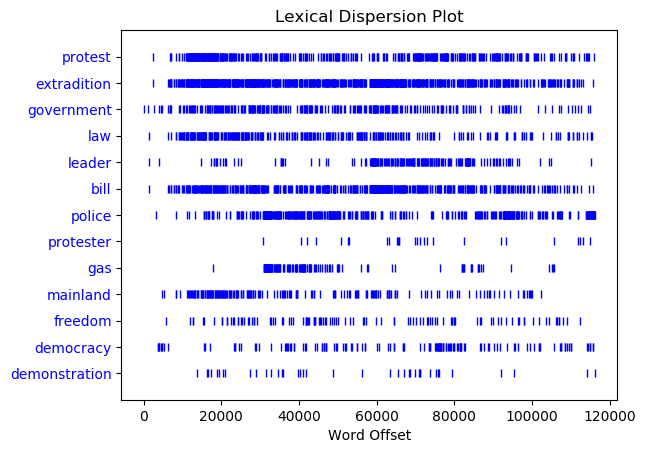

In [66]:
aText = nltk.Text(token)
sns.reset_orig() 
aText.dispersion_plot(['protest',
 'extradition',
 'government',
 'law',
 'leader',
 'bill',
 'police',
 'protester',
 'gas',
 'mainland',
 'freedom',
 'democracy',
 'city',
 'world',
 'demonstration',
 'support',
 'street',
 'country',
 'demonstrator',
 'crowd',
 'demand',
 'force',
 'photo',
 'plan'])
sns.set() 


## 4.2 Top Contributor Similarity Test

In [67]:
#creating a database with only top 15 contributors

In [68]:
jun_topdf = jundf

In [69]:
jun_topdf = jun_topdf.sort_values(by=['top_contributor'], ascending=False)
jun_topdf=jun_topdf.reset_index(drop=True)

In [70]:
jun_topdf[:3]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-06-16 03:02:01+00:00,HongKongFP,"HKFP Lens: The day that shook Hong Kong, Part ...",26,24,2019-06-16,"[HKFP, Lens, The, day, that, shook, Hong, Kong...","[hkfp, lens, day, shook, hong, kong, dramatic,...","[[HKFP, Lens], [The, day, that, shook, Hong, K...","[[hkfp, lens], [day, shake, hong, kong, dramat...",50.0,1,"[[(hkfp, NNP), (lens, NNP), (day, NNP), (shake..."
1,2019-06-11 05:15:38+00:00,Reuters,U.S. warns extradition law changes may jeopard...,30,42,2019-06-11,"[U.S., warns, extradition, law, changes, may, ...","[u.s, warns, extradition, law, changes, jeopar...","[[U.S., warns, extradition, law, changes, may,...","[[u.s, warn, extradition, law, change, jeopard...",72.0,1,"[[(u.s, NNP), (warn, VBP), (extradition, NN), ..."
2,2019-06-17 09:38:27+00:00,TIME,"""It's not the endgame, because the Hong Kong g...",904,1905,2019-06-17,"[It, 's, not, the, endgame, because, the, Hong...","[endgame, hong, kong, government, beijing, tur...","[[It, 's, not, the, endgame, because, the, Hon...","[[endgame, hong, kong, government, beijing, tu...",2809.0,1,"[[(endgame, NNP), (hong, NNP), (kong, NNP), (g..."


In [71]:
for i in range (len(jun_topdf)):
    if jun_topdf['top_contributor'][i] == 0:
        print (i)
        break 


861


In [72]:
jun_topdf = jun_topdf.drop(jun_topdf.index[854:])

In [73]:
jun_topdf[:3]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-06-16 03:02:01+00:00,HongKongFP,"HKFP Lens: The day that shook Hong Kong, Part ...",26,24,2019-06-16,"[HKFP, Lens, The, day, that, shook, Hong, Kong...","[hkfp, lens, day, shook, hong, kong, dramatic,...","[[HKFP, Lens], [The, day, that, shook, Hong, K...","[[hkfp, lens], [day, shake, hong, kong, dramat...",50.0,1,"[[(hkfp, NNP), (lens, NNP), (day, NNP), (shake..."
1,2019-06-11 05:15:38+00:00,Reuters,U.S. warns extradition law changes may jeopard...,30,42,2019-06-11,"[U.S., warns, extradition, law, changes, may, ...","[u.s, warns, extradition, law, changes, jeopar...","[[U.S., warns, extradition, law, changes, may,...","[[u.s, warn, extradition, law, change, jeopard...",72.0,1,"[[(u.s, NNP), (warn, VBP), (extradition, NN), ..."
2,2019-06-17 09:38:27+00:00,TIME,"""It's not the endgame, because the Hong Kong g...",904,1905,2019-06-17,"[It, 's, not, the, endgame, because, the, Hong...","[endgame, hong, kong, government, beijing, tur...","[[It, 's, not, the, endgame, because, the, Hon...","[[endgame, hong, kong, government, beijing, tu...",2809.0,1,"[[(endgame, NNP), (hong, NNP), (kong, NNP), (g..."


In [74]:
jun_topdf = jun_topdf.sort_values(by=['username'], ascending=True)
jun_topdf=jun_topdf.reset_index(drop=True)

In [75]:
jun_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-06-30 22:20:30+00:00,AFP,#BREAKING Hong Kong protesters seize key roads...,227,254,2019-06-30,"[BREAKING, Hong, Kong, protesters, seize, key,...","[breaking, hong, kong, protesters, seize, key,...","[[BREAKING, Hong, Kong, protesters, seize, key...","[[break, hong, kong, protester, seize, key, ro...",481.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (prot..."
1,2019-06-15 04:01:05+00:00,AFP,Hong Kong's embattled government looks set to ...,42,31,2019-06-15,"[Hong, Kong, 's, embattled, government, looks,...","[hong, kong, embattled, government, looks, set...","[[Hong, Kong, 's, embattled, government, looks...","[[hong, kong, embattled, government, look, set...",73.0,1,"[[(hong, NNP), (kong, NNP), (embattled, VBD), ..."
2,2019-06-12 05:56:43+00:00,AFP,Police block a road as protesters rally agains...,65,88,2019-06-12,"[Police, block, a, road, as, protesters, rally...","[police, block, road, protesters, rally, contr...","[[Police, block, a, road, as, protesters, rall...","[[police, block, road, protester, rally, contr...",153.0,1,"[[(police, NN), (block, NNP), (road, NNP), (pr..."
3,2019-06-21 09:03:10+00:00,AFP,VIDEO: Hong Kong police appeal to protesters t...,35,30,2019-06-21,"[VIDEO, Hong, Kong, police, appeal, to, protes...","[video, hong, kong, police, appeal, protesters...","[[VIDEO], [Hong, Kong, police, appeal, to, pro...","[[video], [hong, kong, police, appeal, protest...",65.0,1,"[[(video, NNP), (hong, NNP), (kong, NNP), (pol..."
4,2019-06-21 09:01:32+00:00,AFP,VIDEO: Anti-government demonstrators gather at...,25,25,2019-06-21,"[VIDEO, Anti, government, demonstrators, gathe...","[video, anti, government, demonstrators, gathe...","[[VIDEO], [Anti, government, demonstrators, ga...","[[video], [anti, government, demonstrator, gat...",50.0,1,"[[(video, NNP), (anti, JJ), (government, NN), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,2019-06-22 01:30:06+00:00,nytimes,We stitched together aerial images and stills ...,933,2447,2019-06-22,"[We, stitched, together, aerial, images, and, ...","[stitched, aerial, images, stills, drone, vide...","[[We, stitched, together, aerial, images, and,...","[[stitch, aerial, image, still, drone, video, ...",3380.0,1,"[[(stitch, VB), (aerial, JJ), (image, NN), (st..."
850,2019-06-14 08:00:07+00:00,nytimes,"On Tuesday night, as demonstrators gathered ne...",70,101,2019-06-14,"[On, Tuesday, night, as, demonstrators, gather...","[tuesday, night, demonstrators, gathered, near...","[[On, Tuesday, night, as, demonstrators, gathe...","[[tuesday, night, demonstrator, gather, near, ...",171.0,1,"[[(tuesday, NNP), (night, NN), (demonstrator, ..."
851,2019-06-12 11:33:06+00:00,nytimes,Hong Kong’s commissioner of police described t...,222,226,2019-06-12,"[Hong, Kong, ’s, commissioner, of, police, des...","[hong, kong, commissioner, police, described, ...","[[Hong, Kong, ’s, commissioner, of, police, de...","[[hong, kong, commissioner, police, describe, ...",448.0,1,"[[(hong, NNP), (kong, NNP), (commissioner, NNP..."
852,2019-06-30 20:34:21+00:00,nytimes,The police did not respond to a request for co...,132,288,2019-06-30,"[The, police, did, not, respond, to, a, reques...","[police, respond, request, comment, hong, kong...","[[The, police, did, not, respond, to, a, reque...","[[police, respond, request, comment, hong, kon...",420.0,1,"[[(police, NNS), (respond, NNP), (request, NNP..."


In [76]:
jun_topdf = jun_topdf.sort_values(by=['username'], ascending=True)
jun_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-06-30 22:20:30+00:00,AFP,#BREAKING Hong Kong protesters seize key roads...,227,254,2019-06-30,"[BREAKING, Hong, Kong, protesters, seize, key,...","[breaking, hong, kong, protesters, seize, key,...","[[BREAKING, Hong, Kong, protesters, seize, key...","[[break, hong, kong, protester, seize, key, ro...",481.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (prot..."
54,2019-06-11 04:53:19+00:00,AFP,AFP graphic on how Carrie Lam became Hong Kong...,28,35,2019-06-11,"[AFP, graphic, on, how, Carrie, Lam, became, H...","[afp, graphic, carrie, lam, hong, kong, chief,...","[[AFP, graphic, on, how, Carrie, Lam, became, ...","[[afp, graphic, carrie, lam, hong, kong, chief...",63.0,1,"[[(afp, NNP), (graphic, NNP), (carrie, NNP), (..."
53,2019-06-10 04:38:43+00:00,AFP,VIDEO: Police fight with protesters in Hong Ko...,117,116,2019-06-10,"[VIDEO, Police, fight, with, protesters, in, H...","[video, police, fight, protesters, hong, kong,...","[[VIDEO], [Police, fight, with, protesters, in...","[[video], [police, fight, protester, hong, kon...",233.0,1,"[[(video, NN), (police, NN), (fight, VBP), (pr..."
52,2019-06-10 06:27:41+00:00,AFP,#BREAKING Hong Kong extradition law opponents ...,24,26,2019-06-10,"[BREAKING, Hong, Kong, extradition, law, oppon...","[breaking, hong, kong, extradition, law, oppon...","[[BREAKING, Hong, Kong, extradition, law, oppo...","[[break, hong, kong, extradition, law, opponen...",50.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (extr..."
51,2019-06-11 09:21:42+00:00,AFP,#BREAKING China demands US 'stop interfering' ...,60,39,2019-06-11,"[BREAKING, China, demands, US, stop, interferi...","[breaking, china, demands, stop, interfering, ...","[[BREAKING, China, demands, US, stop, interfer...","[[break, china, demand, stop, interfere, hong,...",99.0,1,"[[(break, VB), (china, NNP), (demand, NN), (st..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,2019-06-17 17:30:14+00:00,nytimes,The Chinese government voiced strong support f...,49,102,2019-06-17,"[The, Chinese, government, voiced, strong, sup...","[chinese, government, voiced, strong, support,...","[[The, Chinese, government, voiced, strong, su...","[[chinese, government, voice, strong, support,...",151.0,1,"[[(chinese, JJ), (government, NN), (voice, NN)..."
827,2019-06-12 05:45:07+00:00,nytimes,The front page of The New York Times for Wedne...,115,221,2019-06-12,"[The, front, page, of, The, New, York, Times, ...","[page, new, york, times, wednesday, june, 12th...","[[The, front, page, of, The, New, York, Times,...","[[page, new, york, time, wednesday, june, 12th...",336.0,1,"[[(page, NNP), (new, NNP), (york, NNP), (time,..."
828,2019-06-12 09:25:37+00:00,nytimes,Riot police turned downtown Hong Kong into a b...,272,358,2019-06-12,"[Riot, police, turned, downtown, Hong, Kong, i...","[riot, police, turned, downtown, hong, kong, b...","[[Riot, police, turned, downtown, Hong, Kong, ...","[[riot, police, turn, downtown, hong, kong, ba...",630.0,1,"[[(riot, NN), (police, NNS), (turn, VBP), (dow..."
819,2019-06-16 13:16:47+00:00,nytimes,Breaking News: Hong Kong's leader apologized t...,190,406,2019-06-16,"[Breaking, News, Hong, Kong, 's, leader, apolo...","[breaking, news, hong, kong, leader, apologize...","[[Breaking, News, Hong, Kong, 's, leader, apol...","[[break, news, hong, kong, leader, apologize, ...",596.0,1,"[[(break, NNP), (news, NN), (hong, NNP), (kong..."


In [80]:
jun_username = jun_topdf['username'].tolist()

jun_countedWords = wordCounter(jun_username)
jun_countedWords

,word,count
0,afp,1
1,cnn,1
2,carlzha,1
3,chinadaily,1
4,hongkongfp,1
5,quicktake,1
6,reuters,1
7,scmpnews,1
8,time,1
9,wsj,1


In [84]:
jun_topdf

,username,text
0,AFP,#BREAKING Hong Kong protesters seize key roads...
1,CNN,Massive demonstrations clogged Hong Kong's str...
2,CarlZha,The irony of a Brit tweeting in support of Hon...
3,ChinaDaily,Parents in the Hong Kong Special Administrativ...
4,HongKongFP,"Initial foolishness, then repeated stubbornnes..."
5,QuickTake,"Is it possible to have your bedroom, kitchen, ..."
6,Reuters,China says will not allow Hong Kong issue to b...
7,SCMPNews,Hong Kong has one of the world's top-ranked he...
8,TIME,Thousands besiege Hong Kong's police headquart...
9,WSJ,Hong Kong's leader plans to suspend an extradi...


In [83]:
jun_topdf = jun_topdf.drop(columns=['date','retweets','favorites','clean date','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])
jun_topdf

KeyError: "['date' 'retweets' 'favorites' 'clean date' 'pop' 'tokenized_words'\n 'normalized_words' 'top_contributor' 'POS_sents'] not found in axis"

In [85]:
jun_topdf = jun_topdf.groupby(['username'], as_index = False).agg({'text': ''.join})


In [86]:
pandas.options.display.max_colwidth = 100
jun_topdf

,username,text
0,AFP,#BREAKING Hong Kong protesters seize key roads on China handover anniversary AFP graphic on how ...
1,CNN,Massive demonstrations clogged Hong Kong's streets on Sunday as protesters urged the government ...
2,CarlZha,The irony of a Brit tweeting in support of Hong Kong Anti-Extradition Bill Protest while UK prep...
3,ChinaDaily,Parents in the Hong Kong Special Administrative Region took to the streets on Sunday to urge US ...
4,HongKongFP,"Initial foolishness, then repeated stubbornness - why Hong Kong Carrie Lam owes us a big apology..."
5,QuickTake,"Is it possible to have your bedroom, kitchen, bathroom, living room and storage space all in les..."
6,Reuters,China says will not allow Hong Kong issue to be discussed at G20 summit http://www.reuters.com/a...
7,SCMPNews,"Hong Kong has one of the world's top-ranked health care systems, but public hospitals are still ..."
8,TIME,Thousands besiege Hong Kong's police headquarters after a day of anti-government protests http:/...
9,WSJ,Hong Kong's leader plans to suspend an extradition bill that had sparked violent protests over B...


In [87]:
#tokenize and normalize

In [88]:
#tokenize words
jun_topdf['tokenized_words'] = jun_topdf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
jun_topdf['normalized_words'] = jun_topdf['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [89]:
jun_topdf

,username,text,tokenized_words,normalized_words
0,AFP,#BREAKING Hong Kong protesters seize key roads on China handover anniversary AFP graphic on how ...,"[BREAKING, Hong, Kong, protesters, seize, key, roads, on, China, handover, anniversary, AFP, gra...","[breaking, hong, kong, protesters, seize, key, roads, china, handover, anniversary, afp, graphic..."
1,CNN,Massive demonstrations clogged Hong Kong's streets on Sunday as protesters urged the government ...,"[Massive, demonstrations, clogged, Hong, Kong, 's, streets, on, Sunday, as, protesters, urged, t...","[massive, demonstrations, clogged, hong, kong, streets, sunday, protesters, urged, government, p..."
2,CarlZha,The irony of a Brit tweeting in support of Hong Kong Anti-Extradition Bill Protest while UK prep...,"[The, irony, of, a, Brit, tweeting, in, support, of, Hong, Kong, Anti, Extradition, Bill, Protes...","[irony, brit, tweeting, support, hong, kong, anti, extradition, bill, protest, uk, prepare, extr..."
3,ChinaDaily,Parents in the Hong Kong Special Administrative Region took to the streets on Sunday to urge US ...,"[Parents, in, the, Hong, Kong, Special, Administrative, Region, took, to, the, streets, on, Sund...","[parents, hong, kong, special, administrative, region, took, streets, sunday, urge, politicians,..."
4,HongKongFP,"Initial foolishness, then repeated stubbornness - why Hong Kong Carrie Lam owes us a big apology...","[Initial, foolishness, then, repeated, stubbornness, why, Hong, Kong, Carrie, Lam, owes, us, a, ...","[initial, foolishness, repeated, stubbornness, hong, kong, carrie, lam, owes, big, apology, noto..."
5,QuickTake,"Is it possible to have your bedroom, kitchen, bathroom, living room and storage space all in les...","[Is, it, possible, to, have, your, bedroom, kitchen, bathroom, living, room, and, storage, space...","[possible, bedroom, kitchen, bathroom, living, room, storage, space, square, feet, hong, kong, p..."
6,Reuters,China says will not allow Hong Kong issue to be discussed at G20 summit http://www.reuters.com/a...,"[China, says, will, not, allow, Hong, Kong, issue, to, be, discussed, at, G20, summit, http://ww...","[china, says, allow, hong, kong, issue, discussed, g20, summit, http://www.reuters.com/article/u..."
7,SCMPNews,"Hong Kong has one of the world's top-ranked health care systems, but public hospitals are still ...","[Hong, Kong, has, one, of, the, world, 's, top, ranked, health, care, systems, but, public, hosp...","[hong, kong, world, ranked, health, care, systems, public, hospitals, plagued, shortage, doctors..."
8,TIME,Thousands besiege Hong Kong's police headquarters after a day of anti-government protests http:/...,"[Thousands, besiege, Hong, Kong, 's, police, headquarters, after, a, day, of, anti, government, ...","[thousands, besiege, hong, kong, police, headquarters, day, anti, government, protests, http://m..."
9,WSJ,Hong Kong's leader plans to suspend an extradition bill that had sparked violent protests over B...,"[Hong, Kong, 's, leader, plans, to, suspend, an, extradition, bill, that, had, sparked, violent,...","[hong, kong, leader, plans, suspend, extradition, bill, sparked, violent, protests, beijing, gro..."


In [91]:
keywords = [(( 'protest',
 'extradition',
 'government',
 'law',
 'leader',
 'bill',
 'police',
 'protester',
 'gas',
 'mainland',
 'freedom',
 'democracy',
 'city',
 'world',
 'demonstration',
 'support',
 'street',
 'country',
 'demonstrator',
 'crowd',
 'demand',
 'force',
 'photo',
 'plan') )]

taggedDocs = []
for index, row in jun_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['username'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
jun_topdf['TaggedAbstracts'] = taggedDocs


In [92]:
topD2V = gensim.models.doc2vec.Doc2Vec(jun_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [93]:
topD2V.docvecs[5]


array([-1.3375423 ,  0.9011448 , -0.8823069 ,  1.3912742 , -0.6044823 ,
        0.09120404,  0.55260843,  0.8940985 ,  0.19390471, -0.04677778,
        0.30263093, -0.43197548,  0.55251026, -0.57159585,  0.8321526 ,
       -0.8188301 , -1.4448788 ,  0.8170159 , -0.61598325, -0.17437525,
       -2.1480389 , -0.14800979, -0.46291104,  0.4948338 ,  0.43876526,
        1.0165161 ,  0.33174884, -0.42647126, -1.7081996 , -0.20862095,
       -0.10358633,  0.5849641 ,  0.4721897 ,  0.1849837 ,  0.2340761 ,
       -0.19567564, -0.7036007 , -0.8401071 , -0.56407744, -0.6060475 ,
        0.36921328, -0.17556487,  0.66663563, -0.01351367, -0.5834    ,
       -0.79467887, -0.939343  ,  0.5148949 , -0.28220397,  0.56671536,
        0.11656275, -0.3614881 , -1.0806869 , -0.06450971,  0.4449849 ,
       -0.7724676 ,  0.16104087,  0.45960438, -0.7701486 , -0.10188564,
        0.4484187 , -0.16325468, -0.6259272 , -0.5087794 ,  0.15362798,
       -0.08465682,  0.4944822 , -0.23482186,  0.6414862 , -1.94

In [94]:
targetDocs = jun_topdf['username']

heatmapMatrixD = []



for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

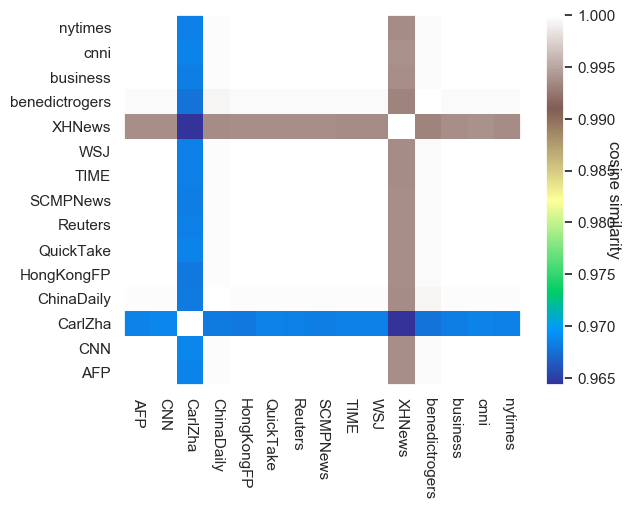

In [95]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [296]:
jun_topdf['text'][11]

"Reports that Hong Kong police are demanding the media leave. That is completely unacceptable. In a society that has any remaining vestiges of freedom or openness, if the media left it gives the police impunity to crackdown illegally and brutally. It must not happen.1/4 Here's an extract of my video message to the people of Hong Kong ahead of the protests on Sunday 9 June against the proposed new extradition law In London I will be speaking tomorrow afternoon at a demonstration for the rights of the people of Hong Kong, outside Parliament, and will have several op-eds coming out too. Hong Kong, I stand with you as we mark the 22nd anniversary of the handover of Hong Kong to China1/5 the first part of my speech in Parliament Square, London, for Hong Kong "

## 4.3 Semantic Influence Networks based on noun-verb pairs
to see check if they are using the same noun-verb pairs


In [97]:
jun_topdf['tokenized_sents'] = jun_topdf['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
jun_topdf['normalized_sents'] = jun_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])


In [98]:
import networkx as nx

In [99]:
g = posCooccurrence(jun_topdf['normalized_sents'].sum(), 'NN', 'VB')

In [100]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [101]:
len(g.nodes)

923

In [102]:
len(g.edges)

1935

In [103]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [106]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(jun_topdf['text'])


In [107]:
tweetVects_incidence.shape


(15, 2471)

In [108]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [109]:
print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 2486
Number of edges: 4897
Average degree:   3.9397


In [110]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 15
Number of edges: 105
Average degree:  14.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


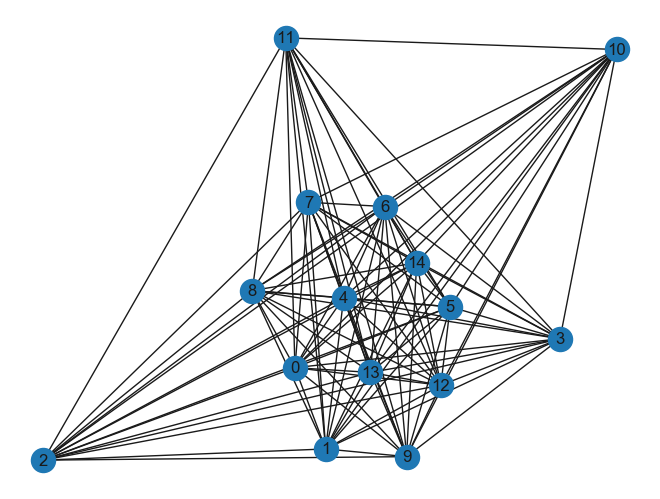

In [111]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [112]:
jun_topdf['text'][14]


'Riot police fired tear gas and rubber bullets in downtown Hong Kong on Wednesday as they repelled tens of thousands of protesters who had swarmed the city’s legislature in anger over proposed legislation that would allow extraditions to mainland China Hong Kong’s top court ruled that a gay civil servant and his husband were entitled to spousal benefits and a joint tax return, the latest example of an Asian government expanding rights for same-sex couples Breaking News: Hong Kong’s leader is backing down after huge protests and will suspend a bill allowing extraditions to China, her advisers said. Protesters in Hong Kong have become more agile and mobile by using Telegram, an encrypted messaging platform, to create public channels to share information and smaller private groups to quickly organize In Opinion The editorial board writes, "The residents of Hong Kong demonstrated once again that they will not easily surrender the civil liberties they learned to regard as their self-evident

# 5. July Analysis

## 5.1 Word Count & Distribution to build Narrative 

In [113]:
juldf['POS_sents'] = juldf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
juldf['POS_sents']


4163    [[(helicopter, NN), (carry, VBP), (chinese, JJ), (hong, NNP), (kong, NNP), (flag, NN), (fly, VBP...
4164    [[(update, NN), (police, NNP), (hong, NNP), (kong, NNP), (use, VBP), (pepper, NNP), (spray, NNP)...
4165                                                   [[(hong, NNP), (kong, NNP), (sar, NNP), (turn, VB)]]
4166    [[(large, JJ), (protest, NN), (expect, VBP), (hong, NNP), (kong, NNP), (mark, NNP), (anniversary...
4167    [[(scene, NNP), (admiralty, NNP), (hong, NNP), (kong, NNP)], [(right, RB), (extraditionbill, NNP...
                                                       ...                                                 
8268    [[(totally, RB), (write, VB), (piece, NN), (experience, NN), (grow, VB), (hong, NNP), (kong, NNP...
8269    [[(check, VB), (space, NNP), (maximize, NNP), (micro, NNP), (apartment, NN), (hong, NNP), (kong,...
8270    [[( , _SP), (fall, VB), (fake, JJ), (news, NN), (photo, NN), (@overgaard, NNP), (hong, NNP), (ko...
8271    [[(@wsjopinion, NNP)

In [303]:
countTarget = 'NN'
targetCounts = {}
for entry in juldf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1


In [304]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [305]:
pandas.DataFrame(sortedTargets)[:15]

,0,1
0,protest,668
1,government,262
2,protester,237
3,police,230
4,democracy,202
5,gas,155
6,today,153
7,extradition,149
8,time,148
9,violence,129


In [306]:
#turn the sorted targets to a list for easire copy and paste later
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [307]:
nntoken [:30]

['protest',
 'government',
 'protester',
 'police',
 'democracy',
 'gas',
 'today',
 'extradition',
 'time',
 'violence',
 'attack',
 'support',
 'freedom',
 'week',
 'storm',
 'fire',
 'year',
 'leader',
 'demonstrator',
 'riot',
 'station',
 'world',
 'city',
 'day',
 'night',
 'event',
 'antielab',
 'mainland',
 'law',
 'video']

In [308]:
#check the context of the word

In [309]:
import nltk
import seaborn as sns #makes our plots look nicer
all_words = juldf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)

In [310]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 

In [311]:
cleantoken = lucem_illud_2020.normalizeTokens(token, lemma=False)


In [312]:
#tokenize words
allcountedWords = wordCounter(cleantoken)

In [313]:
allcountedWords[:5]

,word,count
0,helicopters,2
1,carrying,10
2,chinese,298
3,hong,4530
4,kong,4511


In [314]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
allcountedWords.sort_values('count', ascending=False, inplace=True)


In [315]:
allcountedWords[0:15]

,word,count
3,hong,4530
4,kong,4511
8,protesters,861
30,china,720
12,police,623
35,protests,508
108,people,488
2,chinese,298
18,government,268
25,democracy,255


In [318]:
a = allcountedWords['word'][:15].tolist()
a

['hong',
 'kong',
 'protesters',
 'china',
 'police',
 'protests',
 'people',
 'chinese',
 'government',
 'democracy',
 'protest',
 'amp',
 'city',
 'new',
 'extradition']

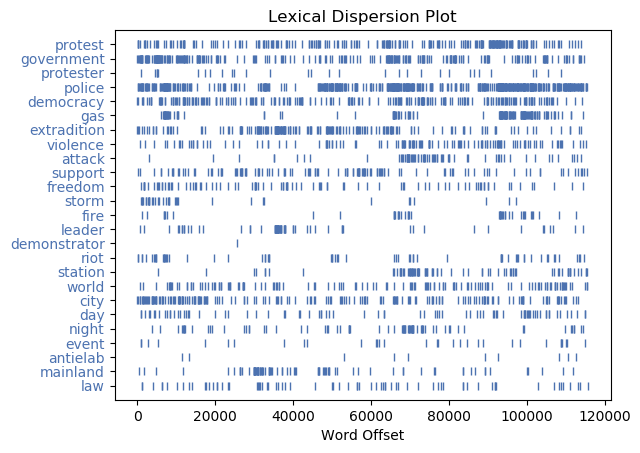

In [319]:
aText = nltk.Text(token)
sns.reset_orig() 
aText.dispersion_plot([ 'protest',
 'government',
 'protester',
 'police',
 'democracy',
 'gas',
 'extradition',
 'violence',
 'attack',
 'support',
 'freedom',
 'storm',
 'fire',
 'leader',
 'demonstrator',
 'riot',
 'station',
 'world',
 'city',
 'day',
 'night',
 'event',
 'antielab',
 'mainland',
 'law'])
sns.set() 


In [351]:
aIndex.print_concordance('airport', width=140, lines=500)

Displaying 7 of 7 matches:
5a8286673.pdf Came back in Hong Kong well as soon as I arrived at airport I came to office directly coz today we start an important project
ith @AOBrien_news for @SBSNews in Hong Kong NU’EST Minhyun at the airport earlier heading to Hong Kong @NUESTNEWS Safe flight to Hong Kong 
ople whose fate is at stake here Anyone passing through Hong Kong airport could be detained and sent to China BREAKING Hong Kong delays the
ong Kong 29 Bounce Back +9 NEW PEAK THE BOYZ looking great at the airport as they make their way to Hong Kong for their fanmeeting~ @Creker
vpuEUiOg Pray for no geoblocking Anyone passing through Hong Kong airport could be detained and sent to China compare the Huawei Vancouver 
 known to have made critical remarks of the CCP held at Hong Kong airport Had HK had the extradition law now suspended he could be someone 
ioned then deported by immigration officers at Hong Kong ’s int’l airport Hong Kong has suddenly turned into the world 's best stock 

In [347]:
aText.common_contexts(['attack'])

this_on to_what service_freedom ddos_on cyber_company cyber_that
cyber_to hacking_during cyber_during ddos_from cyber_was ddos_during
to_their police_journalists under_what to_our to_her


## 5.2 Top Contributor Similarity Test¶

In [127]:
#creating a database with only top 15 contributors

In [163]:
jul_topdf = juldf

In [164]:
jul_topdf = jul_topdf.sort_values(by=['top_contributor'], ascending=False)
jul_topdf=jul_topdf.reset_index(drop=True)

In [165]:
jul_topdf[:]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-07-26 23:53:31+00:00,CarlZha,Hong Kong protesters physically re-educate Mandarin speaking Chinese mainlander in freedom of sp...,45,79,2019-07-26,"[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, f...","[hong, kong, protesters, physically, educate, mandarin, speaking, chinese, mainlander, freedom, ...","[[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, ...","[[hong, kong, protester, physically, educate, mandarin, speak, chinese, mainlander, freedom, spe...",124.0,1,"[[(hong, NNP), (kong, NNP), (protester, NNP), (physically, RB), (educate, VBP), (mandarin, NNP),..."
1,2019-07-08 00:07:36+00:00,business,"By numbers, storm, siege, surprise: Here’s how Hong Kong kept the pressure on China during a mon...",17,39,2019-07-08,"[By, numbers, storm, siege, surprise, Here, ’s, how, Hong, Kong, kept, the, pressure, on, China,...","[numbers, storm, siege, surprise, hong, kong, kept, pressure, china, month, historic, demonstrat...","[[By, numbers, storm, siege, surprise], [Here, ’s, how, Hong, Kong, kept, the, pressure, on, Chi...","[[number, storm, siege, surprise], [hong, kong, keep, pressure, china, month, historic, demonstr...",56.0,1,"[[(number, NN), (storm, NN), (siege, NNP), (surprise, NN), (hong, NNP), (kong, NNP), (keep, VBP)..."
2,2019-07-08 03:48:16+00:00,AFP,VIDEO: Fresh clashes in Hong Kong after huge march to China station. Riot police baton-charge an...,260,170,2019-07-08,"[VIDEO, Fresh, clashes, in, Hong, Kong, after, huge, march, to, China, station, Riot, police, ba...","[video, fresh, clashes, hong, kong, huge, march, china, station, riot, police, baton, charge, an...","[[VIDEO], [Fresh, clashes, in, Hong, Kong, after, huge, march, to, China, station], [Riot, polic...","[[video], [fresh, clash, hong, kong, huge, march, china, station], [riot, police, baton, charge,...",430.0,1,"[[(video, NNP), (fresh, JJ), (clash, NNP), (hong, NNP), (kong, NNP), (huge, NNP), (march, NNP)],..."
3,2019-07-26 20:45:00+00:00,Reuters,"Protesters calling for democracy converged on Hong Kong airport, with some chanting ‘free Hong K...",63,106,2019-07-26,"[Protesters, calling, for, democracy, converged, on, Hong, Kong, airport, with, some, chanting, ...","[protesters, calling, democracy, converged, hong, kong, airport, chanting, free, hong, kong, rea...","[[Protesters, calling, for, democracy, converged, on, Hong, Kong, airport, with, some, chanting,...","[[protester, call, democracy, converge, hong, kong, airport, chant, free, hong, kong], [read], [...",169.0,1,"[[(protester, NNP), (call, VB), (democracy, NN), (converge, NNP), (hong, NNP), (kong, NNP), (air..."
4,2019-07-08 03:16:06+00:00,HongKongFP,Riot police baton charge Hong Kong demonstrators in fresh escalation of anti-extradition protest...,26,29,2019-07-08,"[Riot, police, baton, charge, Hong, Kong, demonstrators, in, fresh, escalation, of, anti, extrad...","[riot, police, baton, charge, hong, kong, demonstrators, fresh, escalation, anti, extradition, p...","[[Riot, police, baton, charge, Hong, Kong, demonstrators, in, fresh, escalation, of, anti, extra...","[[riot, police, baton, charge, hong, kong, demonstrator, fresh, escalation, anti, extradition, p...",55.0,1,"[[(riot, NN), (police, NNP), (baton, NNP), (charge, NNP), (hong, NNP), (kong, NNP), (demonstrato..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4105,2019-07-12 08:43:30+00:00,minjuiced,"They've safely arrived at Hong Kong.. Security looks strict today, good. https://twitter.com/V7r...",117,275,2019-07-12,"[They, 've, safely, arrived, at, Hong, Kong, Security, looks, strict, today, good, https://twitt...","[ve, safely, arrived, hong, kong, security, looks, strict, today, good, https://twitter.com/v7rc...","[[They, 've, safely, arrived, at, Hong, Kong], [Security, looks, strict

In [166]:
for i in range (len(jul_topdf)):
    if jul_topdf['top_contributor'][i] == 0:
        print (i)
        break 


804


In [167]:
jul_topdf = jul_topdf.drop(jul_topdf.index[804:])

In [170]:
jul_topdf[:]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-07-26 23:53:31+00:00,CarlZha,Hong Kong protesters physically re-educate Mandarin speaking Chinese mainlander in freedom of sp...,45,79,2019-07-26,"[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, f...","[hong, kong, protesters, physically, educate, mandarin, speaking, chinese, mainlander, freedom, ...","[[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, ...","[[hong, kong, protester, physically, educate, mandarin, speak, chinese, mainlander, freedom, spe...",124.0,1,"[[(hong, NNP), (kong, NNP), (protester, NNP), (physically, RB), (educate, VBP), (mandarin, NNP),..."
1,2019-07-08 00:07:36+00:00,business,"By numbers, storm, siege, surprise: Here’s how Hong Kong kept the pressure on China during a mon...",17,39,2019-07-08,"[By, numbers, storm, siege, surprise, Here, ’s, how, Hong, Kong, kept, the, pressure, on, China,...","[numbers, storm, siege, surprise, hong, kong, kept, pressure, china, month, historic, demonstrat...","[[By, numbers, storm, siege, surprise], [Here, ’s, how, Hong, Kong, kept, the, pressure, on, Chi...","[[number, storm, siege, surprise], [hong, kong, keep, pressure, china, month, historic, demonstr...",56.0,1,"[[(number, NN), (storm, NN), (siege, NNP), (surprise, NN), (hong, NNP), (kong, NNP), (keep, VBP)..."
2,2019-07-08 03:48:16+00:00,AFP,VIDEO: Fresh clashes in Hong Kong after huge march to China station. Riot police baton-charge an...,260,170,2019-07-08,"[VIDEO, Fresh, clashes, in, Hong, Kong, after, huge, march, to, China, station, Riot, police, ba...","[video, fresh, clashes, hong, kong, huge, march, china, station, riot, police, baton, charge, an...","[[VIDEO], [Fresh, clashes, in, Hong, Kong, after, huge, march, to, China, station], [Riot, polic...","[[video], [fresh, clash, hong, kong, huge, march, china, station], [riot, police, baton, charge,...",430.0,1,"[[(video, NNP), (fresh, JJ), (clash, NNP), (hong, NNP), (kong, NNP), (huge, NNP), (march, NNP)],..."
3,2019-07-26 20:45:00+00:00,Reuters,"Protesters calling for democracy converged on Hong Kong airport, with some chanting ‘free Hong K...",63,106,2019-07-26,"[Protesters, calling, for, democracy, converged, on, Hong, Kong, airport, with, some, chanting, ...","[protesters, calling, democracy, converged, hong, kong, airport, chanting, free, hong, kong, rea...","[[Protesters, calling, for, democracy, converged, on, Hong, Kong, airport, with, some, chanting,...","[[protester, call, democracy, converge, hong, kong, airport, chant, free, hong, kong], [read], [...",169.0,1,"[[(protester, NNP), (call, VB), (democracy, NN), (converge, NNP), (hong, NNP), (kong, NNP), (air..."
4,2019-07-08 03:16:06+00:00,HongKongFP,Riot police baton charge Hong Kong demonstrators in fresh escalation of anti-extradition protest...,26,29,2019-07-08,"[Riot, police, baton, charge, Hong, Kong, demonstrators, in, fresh, escalation, of, anti, extrad...","[riot, police, baton, charge, hong, kong, demonstrators, fresh, escalation, anti, extradition, p...","[[Riot, police, baton, charge, Hong, Kong, demonstrators, in, fresh, escalation, of, anti, extra...","[[riot, police, baton, charge, hong, kong, demonstrator, fresh, escalation, anti, extradition, p...",55.0,1,"[[(riot, NN), (police, NNP), (baton, NNP), (charge, NNP), (hong, NNP), (kong, NNP), (demonstrato..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,2019-07-01 01:00:02+00:00,nytimes,Live updates on the Hong Kong protest: Hundreds of riot police officers used batons and pepper s...,75,105,2019-07-01,"[Live, updates, on, the, Hong, Kong, protest, Hundreds, of, riot, police, officers, used, batons...","[live, updates, hong, kong, protest, hundreds, riot, police, officers, batons, pepper, spray, pu...","[[Live, updates, on, the, Hong, Kong, protest, Hundreds, of, riot, police, of

In [171]:
jul_topdf = jul_topdf.sort_values(by=['username'], ascending=True)
jul_topdf=jul_topdf.reset_index(drop=True)

In [172]:
jul_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-07-09 04:33:36+00:00,AFP,"#BREAKING Hong Kong protest group vows new rallies, rejects city leader's comments",79,87,2019-07-09,"[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments]","[breaking, hong, kong, protest, group, vows, new, rallies, rejects, city, leader, comments]","[[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments]]","[[break, hong, kong, protest, group, vow, new, rally, reject, city, leader, comment]]",166.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (protest, NNP), (group, NNP), (vow, NNP), (new, NNP), (..."
1,2019-07-01 00:20:03+00:00,AFP,#UPDATE Police in Hong Kong use pepper spray and batons against anti-government protesters who s...,172,167,2019-07-01,"[UPDATE, Police, in, Hong, Kong, use, pepper, spray, and, batons, against, anti, government, pro...","[update, police, hong, kong, use, pepper, spray, batons, anti, government, protesters, seized, h...","[[UPDATE, Police, in, Hong, Kong, use, pepper, spray, and, batons, against, anti, government, pr...","[[update, police, hong, kong, use, pepper, spray, baton, anti, government, protester, seize, hig...",339.0,1,"[[(update, NN), (police, NNP), (hong, NNP), (kong, NNP), (use, VBP), (pepper, NNP), (spray, NNP)..."
2,2019-07-02 09:54:41+00:00,AFP,"#UPDATE China has rebuked Donald Trump for ""gross interference"" in Hong Kong's affairs after the...",41,43,2019-07-02,"[UPDATE, China, has, rebuked, Donald, Trump, for, gross, interference, in, Hong, Kong, 's, affai...","[update, china, rebuked, donald, trump, gross, interference, hong, kong, affairs, president, sai...","[[UPDATE, China, has, rebuked, Donald, Trump, for, gross, interference, in, Hong, Kong, 's, affa...","[[update, china, rebuke, donald, trump, gross, interference, hong, kong, affair, president, say,...",84.0,1,"[[(update, NNP), (china, NNP), (rebuke, NNP), (donald, NNP), (trump, NNP), (gross, JJ), (interfe..."
3,2019-07-27 09:23:54+00:00,AFP,#BREAKING Hong Kong police fire tear gas at 'anti-triad' rally: TV,62,44,2019-07-27,"[BREAKING, Hong, Kong, police, fire, tear, gas, at, anti, triad, rally, TV]","[breaking, hong, kong, police, fire, tear, gas, anti, triad, rally, tv]","[[BREAKING, Hong, Kong, police, fire, tear, gas, at, anti, triad, rally, TV]]","[[break, hong, kong, police, fire, tear, gas, anti, triad, rally, tv]]",106.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (police, NN), (fire, NN), (tear, JJ), (gas, NN), (anti,..."
4,2019-07-02 10:53:09+00:00,AFP,"VIDEO: Joshua Wong, an activist who became the face of Hong Kong's 2014 pro-democracy ""Umbrella ...",60,97,2019-07-02,"[VIDEO, Joshua, Wong, an, activist, who, became, the, face, of, Hong, Kong, 's, 2014, pro, democ...","[video, joshua, wong, activist, face, hong, kong, pro, democracy, umbrella, movement, says, advo...","[[VIDEO], [Joshua, Wong, an, activist, who, became, the, face, of, Hong, Kong, 's, 2014, pro, de...","[[video], [joshua, wong, activist, face, hong, kong, pro, democracy, umbrella, movement, say, ad...",157.0,1,"[[(video, NNP), (joshua, NNP), (wong, NNP), (activist, NN), (face, VBP)], [(hong, NNP), (kong, N..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,2019-07-02 12:15:03+00:00,nytimes,Watch: The streets of Hong Kong were once again filled with protesters pushing back on China’s e...,53,97,2019-07-02,"[Watch, The, streets, of, Hong, Kong, were, once, again, filled, with, protesters, pushing, back...","[watch, streets, hong, kong, filled, protesters, pushing, china, encroachment, ground, demonstra...","[[Watch, The, streets, of, Hong, Kong, were, once, again, filled, with, protesters, pushing, bac...","[[watch, street, hong, kong, fill, protester, push, china, encroachment], [grind, demonstrator]]",150.0,1,"[[(watch, NNP), (street, NNP), (hong, NNP), (kong, NNP), (fill, N

In [173]:
jul_topdf = jul_topdf.sort_values(by=['username'], ascending=True)
jul_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-07-09 04:33:36+00:00,AFP,"#BREAKING Hong Kong protest group vows new rallies, rejects city leader's comments",79,87,2019-07-09,"[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments]","[breaking, hong, kong, protest, group, vows, new, rallies, rejects, city, leader, comments]","[[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments]]","[[break, hong, kong, protest, group, vow, new, rally, reject, city, leader, comment]]",166.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (protest, NNP), (group, NNP), (vow, NNP), (new, NNP), (..."
50,2019-07-01 17:06:15+00:00,AFP,#BREAKING Hong Kong police retake parliament from anti-government protesters: AFP,43,34,2019-07-01,"[BREAKING, Hong, Kong, police, retake, parliament, from, anti, government, protesters, AFP]","[breaking, hong, kong, police, retake, parliament, anti, government, protesters, afp]","[[BREAKING, Hong, Kong, police, retake, parliament, from, anti, government, protesters, AFP]]","[[break, hong, kong, police, retake, parliament, anti, government, protester, afp]]",77.0,1,"[[(break, VB), (hong, NNP), (kong, NNP), (police, NNP), (retake, NN), (parliament, NNP), (anti, ..."
49,2019-07-21 10:42:24+00:00,AFP,"VIDEO: In a huge march that marks the seventh straight weekend of protests in Hong Kong, demonst...",51,67,2019-07-21,"[VIDEO, In, a, huge, march, that, marks, the, seventh, straight, weekend, of, protests, in, Hong...","[video, huge, march, marks, seventh, straight, weekend, protests, hong, kong, demonstrators, mar...","[[VIDEO], [In, a, huge, march, that, marks, the, seventh, straight, weekend, of, protests, in, H...","[[video], [huge, march, mark, 7, straight, weekend, protest, hong, kong, demonstrator, march, pa...",118.0,1,"[[(video, NNP), (huge, JJ), (march, NNP), (mark, NNP)], [(7, CD), (straight, JJ), (weekend, NN),..."
48,2019-07-28 13:00:00+00:00,AFP,VIDEO: Hong Kong police make multiple arrests after they fired tear gas and rubber bullets to di...,115,81,2019-07-28,"[VIDEO, Hong, Kong, police, make, multiple, arrests, after, they, fired, tear, gas, and, rubber,...","[video, hong, kong, police, multiple, arrests, fired, tear, gas, rubber, bullets, disperse, pro,...","[[VIDEO], [Hong, Kong, police, make, multiple, arrests, after, they, fired, tear, gas, and, rubb...","[[video], [hong, kong, police, multiple, arrest, fire, tear, gas, rubber, bullet, disperse, pro,...",196.0,1,"[[(video, NNP), (hong, NNP), (kong, NNP), (police, NN), (multiple, JJ), (arrest, NN), (fire, NN)..."
47,2019-07-29 01:02:54+00:00,AFP,Some of the great coverage from @AFP photographer Anthony Wallace @AntAFP of clashes between pol...,95,75,2019-07-29,"[Some, of, the, great, coverage, from, @AFP, photographer, Anthony, Wallace, @AntAFP, of, clashe...","[great, coverage, @afp, photographer, anthony, wallace, @antafp, clashes, police, protesters, ho...","[[Some, of, the, great, coverage, from, @AFP, photographer, Anthony, Wallace, @AntAFP, of, clash...","[[great, coverage, @afp, photographer, anthony, wallace, @antafp, clash, police, protester, hong...",170.0,1,"[[(great, JJ), (coverage, NN), (@afp, NNP)], [(photographer, NN), (anthony, NNP), (wallace, NNP)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,2019-07-22 07:30:08+00:00,nytimes,"Hong Kong’s leader will not be making further concessions to the city’s protesters, two of her t...",57,107,2019-07-22,"[Hong, Kong, ’s, leader, will, not, be, making, further, concessions, to, the, city, ’s, protest...","[hong, kong, leader, making, concessions, city, protesters, advisers, said, government, digs, de...","[[Hong, Kong, ’s, leader, will, not, be, making, further, concessions, to, the, city, ’s, protes...","[[hong, kong, leader, make, concession, city, protester, adviser, say, government, dig, despite,.

In [174]:
jul_username = jul_topdf['username'].tolist()

jul_countedWords = wordCounter(jul_username)
jul_countedWords

,word,count
0,afp,70
1,cnn,34
2,carlzha,31
3,chinadaily,25
4,hongkongfp,102
5,quicktake,140
6,reuters,147
7,scmpnews,41
8,time,37
9,wsj,29


In [175]:
jul_topdf = jul_topdf.drop(columns=['date','retweets','favorites','clean date','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])
jul_topdf


,username,text,tokenized_sents,normalized_sents
0,AFP,"#BREAKING Hong Kong protest group vows new rallies, rejects city leader's comments","[[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments]]","[[break, hong, kong, protest, group, vow, new, rally, reject, city, leader, comment]]"
50,AFP,#BREAKING Hong Kong police retake parliament from anti-government protesters: AFP,"[[BREAKING, Hong, Kong, police, retake, parliament, from, anti, government, protesters, AFP]]","[[break, hong, kong, police, retake, parliament, anti, government, protester, afp]]"
49,AFP,"VIDEO: In a huge march that marks the seventh straight weekend of protests in Hong Kong, demonst...","[[VIDEO], [In, a, huge, march, that, marks, the, seventh, straight, weekend, of, protests, in, H...","[[video], [huge, march, mark, 7, straight, weekend, protest, hong, kong, demonstrator, march, pa..."
48,AFP,VIDEO: Hong Kong police make multiple arrests after they fired tear gas and rubber bullets to di...,"[[VIDEO], [Hong, Kong, police, make, multiple, arrests, after, they, fired, tear, gas, and, rubb...","[[video], [hong, kong, police, multiple, arrest, fire, tear, gas, rubber, bullet, disperse, pro,..."
47,AFP,Some of the great coverage from @AFP photographer Anthony Wallace @AntAFP of clashes between pol...,"[[Some, of, the, great, coverage, from, @AFP, photographer, Anthony, Wallace, @AntAFP, of, clash...","[[great, coverage, @afp, photographer, anthony, wallace, @antafp, clash, police, protester, hong..."
...,...,...,...,...
773,nytimes,"Hong Kong’s leader will not be making further concessions to the city’s protesters, two of her t...","[[Hong, Kong, ’s, leader, will, not, be, making, further, concessions, to, the, city, ’s, protes...","[[hong, kong, leader, make, concession, city, protester, adviser, say, government, dig, despite,..."
774,nytimes,"In Opinion Jimmy Lai writes, ""As riot police officers used pepper spray and batons on demonstrat...","[[In, Opinion, Jimmy, Lai, writes, As, riot, police, officers, used, pepper, spray, and, batons,...","[[opinion, jimmy, lai, write, riot, police, officer, pepper, spray, baton, demonstrator, hong, k..."
775,nytimes,"In Opinion Stéphanie Giry writes, ""The Hong Kong police should have intervened to prevent the br...","[[In, Opinion, Stéphanie, Giry, writes, The, Hong, Kong, police, should, have, intervened, to, p...","[[opinion, stéphanie, giry, write, hong, kong, police, intervene, prevent, break, legco], [stop,..."
764,nytimes,"Black-clad demonstrators rallied in Hong Kong’s airport on Friday, filling the arrivals hall of ...","[[Black, clad, demonstrators, rallied, in, Hong, Kong, ’s, airport, on, Friday, filling, the, ar...","[[black, clothe, demonstrator, rally, hong, kong, airport, friday, fill, arrival, hall, world, b..."


In [176]:
jul_topdf = jul_topdf.groupby(['username'], as_index = False).agg({'text': ''.join})


In [177]:
pandas.options.display.max_colwidth = 100
jul_topdf

,username,text
0,AFP,"#BREAKING Hong Kong protest group vows new rallies, rejects city leader's comments #BREAKING Hon..."
1,CNN,"""This kind of severe illegal action damages Hong Kong's rule of law, social order and hurts Hong..."
2,CarlZha,Hong Kong protesters physically re-educate Mandarin speaking Chinese mainlander in freedom of sp...
3,ChinaDaily,Hong Kong's MTR Corp warned of delays Tuesday because of protesters crowding onto subway platfor...
4,HongKongFP,Hong Kong's anti-extradition protests: why Chinese media reports focus on Britain's colonial pas...
5,QuickTake,"Indonesia returned 57 containers of waste it says contained toxic materials to the U.S., Austral..."
6,Reuters,The Chinese military commander responsible for Hong Kong has assured a Pentagon official that Ch...
7,SCMPNews,Cook caught up in shocking violence at Hong Kong MTR station recalls horrific ordeal as 20 peopl...
8,TIME,"""The bill is dead."" Hong Kong's leader vows to kill a controversial extradition plan after weeks..."
9,WSJ,Hong Kong police fire tear gas canisters at demonstrators after earlier pushing back protesters ...


In [178]:
#tokenize and normalize

In [354]:
#tokenize words
jul_topdf['tokenized_words'] = jul_topdf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
jul_topdf['normalized_words'] = jul_topdf['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [355]:
jul_topdf

,username,text,tokenized_words,normalized_words,TaggedAbstracts,tokenized_sents,normalized_sents
0,AFP,"#BREAKING Hong Kong protest group vows new rallies, rejects city leader's comments #BREAKING Hon...","[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments, ...","[breaking, hong, kong, protest, group, vows, new, rallies, rejects, city, leader, comments, brea...","([breaking, hong, kong, protest, group, vows, new, rallies, rejects, city, leader, comments, bre...","[[BREAKING, Hong, Kong, protest, group, vows, new, rallies, rejects, city, leader, 's, comments,...","[[break, hong, kong, protest, group, vow, new, rally, reject, city, leader, comment, break, hong..."
1,CNN,"""This kind of severe illegal action damages Hong Kong's rule of law, social order and hurts Hong...","[This, kind, of, severe, illegal, action, damages, Hong, Kong, 's, rule, of, law, social, order,...","[kind, severe, illegal, action, damages, hong, kong, rule, law, social, order, hurts, hong, kong...","([kind, severe, illegal, action, damages, hong, kong, rule, law, social, order, hurts, hong, kon...","[[This, kind, of, severe, illegal, action, damages, Hong, Kong, 's, rule, of, law, social, order...","[[kind, severe, illegal, action, damage, hong, kong, rule, law, social, order, hurt, hong, kong,..."
2,CarlZha,Hong Kong protesters physically re-educate Mandarin speaking Chinese mainlander in freedom of sp...,"[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, f...","[hong, kong, protesters, physically, educate, mandarin, speaking, chinese, mainlander, freedom, ...","([hong, kong, protesters, physically, educate, mandarin, speaking, chinese, mainlander, freedom,...","[[Hong, Kong, protesters, physically, re, educate, Mandarin, speaking, Chinese, mainlander, in, ...","[[hong, kong, protester, physically, educate, mandarin, speak, chinese, mainlander, freedom, spe..."
3,ChinaDaily,Hong Kong's MTR Corp warned of delays Tuesday because of protesters crowding onto subway platfor...,"[Hong, Kong, 's, MTR, Corp, warned, of, delays, Tuesday, because, of, protesters, crowding, onto...","[hong, kong, mtr, corp, warned, delays, tuesday, protesters, crowding, subway, platforms, disrup...","([hong, kong, mtr, corp, warned, delays, tuesday, protesters, crowding, subway, platforms, disru...","[[Hong, Kong, 's, MTR, Corp, warned, of, delays, Tuesday, because, of, protesters, crowding, ont...","[[hong, kong, mtr, corp, warn, delay, tuesday, protester, crowd, subway, platform, disrupt, comm..."
4,HongKongFP,Hong Kong's anti-extradition protests: why Chinese media reports focus on Britain's colonial pas...,"[Hong, Kong, 's, anti, extradition, protests, why, Chinese, media, reports, focus, on, Britain, ...","[hong, kong, anti, extradition, protests, chinese, media, reports, focus, britain, colonial, pas...","([hong, kong, anti, extradition, protests, chinese, media, reports, focus, britain, colonial, pa...","[[Hong, Kong, 's, anti, extradition, protests, why, Chinese, media, reports, focus, on, Britain,...","[[hong, kong, anti, extradition, protest, chinese, medium, report, focus, britain, colonial, pas..."
5,QuickTake,"Indonesia returned 57 containers of waste it says contained toxic materials to the U.S., Austral...","[Indonesia, returned, 57, containers, of, waste, it, says, contained, toxic, materials, to, the,...","[indonesia, returned, containers, waste, says, contained, toxic, materials, u.s, australia, fran...","([indonesia, returned, containers, waste, says, contained, toxic, materials, u.s, australia, fra...","[[Indonesia, returned, 57, containers, of, waste, it, says, contained, toxic, materials, to, the...","[[indonesia, return, container, waste, say, contain, toxic, material, u.s, australia, france, ge..."
6,Reuters,The Chinese military commander responsible for Hong Kong has assured a Pentagon official that Ch...,"[The, Chinese, military, commander, responsible, for, Hong, Kong,

In [367]:
keywords = [((  'protest',
 'government',
 'protester',
 'police',
 'democracy',
 'gas',
 'extradition',
 'violence',
 'attack',
 'support',
 'freedom',
 'storm',
 'fire',
 'leader',
 'demonstrator',
 'riot',
 'station',
 'world',
 'city',
 'day',
 'night',
 'event',
 'antielab',
 'mainland',
 'law') )]

taggedDocs = []
for index, row in jul_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['username'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
jul_topdf['TaggedAbstracts'] = taggedDocs

In [368]:
topD2V = gensim.models.doc2vec.Doc2Vec(jul_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [369]:
topD2V.docvecs[5]


array([-1.03937638e+00,  9.74958718e-01, -4.35224533e-01,  9.26944673e-01,
       -2.81597316e-01,  5.25040984e-01,  5.01707315e-01,  6.31215453e-01,
        4.04337235e-02, -4.43783551e-01, -4.80222285e-01, -2.60816991e-01,
        8.79334569e-01, -3.02265584e-01,  6.38996243e-01, -4.55681115e-01,
       -8.32905531e-01,  7.77055204e-01, -7.27251887e-01,  1.71204612e-01,
       -2.20229077e+00, -6.45740926e-01, -1.37717736e+00,  3.73548716e-01,
        1.33229485e-02,  3.98325801e-01, -7.73988664e-02, -8.83357465e-01,
       -2.41634679e+00,  3.68141711e-01, -2.69527912e-01,  1.21228945e+00,
        7.39704370e-01,  2.18616664e-01,  2.70095348e-01, -4.27432269e-01,
       -4.20791775e-01, -1.00941992e+00, -5.28623641e-01, -3.39698493e-01,
        5.16442955e-01, -5.87185383e-01,  6.76161587e-01, -9.53632116e-01,
       -5.04837513e-01, -4.03265089e-01, -1.76109791e+00,  4.61492628e-01,
        3.35859917e-02,  1.77030101e-01,  1.75564438e-01, -5.83431125e-01,
       -1.42470348e+00,  

In [370]:
targetDocs = jul_topdf['username']

heatmapMatrixD = []



for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

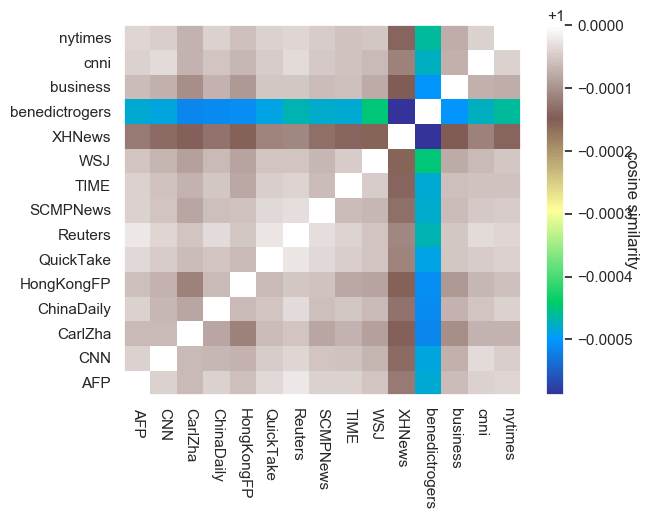

In [371]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [391]:
jul_topdf['text'][10]

'Carrying 1,100+ passengers on 2,450 km-long route, bullet train from N China\'s Tianjin to S China\'s Hong Kong cost 10 hours with less than 160 U.S. dollars China on Wednesday expressed strong dissatisfaction with and firm opposition to the recent comments on Hong Kong made by British Foreign Secretary Jeremy Hunt, urging him to stop wanton interference in Hong Kong affairs http://xhne.ws/Ts2CYChina says it does not allow any foreign interference in Hong Kong affairs http://xhne.ws/k9s7fA central government spokesperson calls on people in Hong Kong to take a clear-cut stand to oppose and resist violence Hong Kong residents show their support for the police, hoping they continue to enforce the law strictly and maintain order and security in the region Continued violence in China\'s Hong Kong crossing the line, and it is terrible disrespect in any country: Hong Kong citizens http://xhne.ws/dDnW2A direct high-speed train service is launched between north China\'s Tianjin and Hong Kong. 

## 5.3 Semantic Influence Networks based on noun-verb pairs

In [188]:
jul_topdf['tokenized_sents'] = jul_topdf['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
jul_topdf['normalized_sents'] = jul_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])


In [189]:
import networkx as nx

In [190]:
g = posCooccurrence(jul_topdf['normalized_sents'].sum(), 'NN', 'VB')

In [191]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [192]:
len(g.nodes)

951

In [193]:
len(g.edges)

1490

In [194]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [195]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(jul_topdf['text'])


In [196]:
tweetVects_incidence.shape


(15, 2522)

In [197]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [198]:
print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 2537
Number of edges: 5058
Average degree:   3.9874


In [199]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 15
Number of edges: 105
Average degree:  14.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


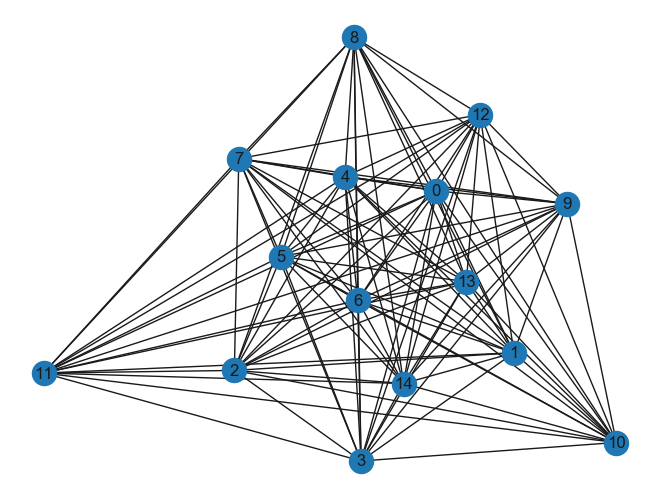

In [200]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [203]:
jul_topdf['text'][8]


'"The bill is dead." Hong Kong\'s leader vows to kill a controversial extradition plan after weeks of protest http://mag.time.com/123gucFHong Kong\'s leader offers no solutions after night of violence Tensions mount in Hong Kong as protesters call for Chief Executive Carrie Lam\'s resignation http://mag.time.com/jLwLJPxEnraged protesters storm the legislature on the anniversary of Hong Kong’s return to Chinese sovereignty "I want to live in a place that upholds the core value that I believe." Hong Kong\'s Ventus Lau is the face of a faceless protest http://mag.time.com/oRnymSXThe Hong Kong protesters are on TIME\'s list of the most influential people on the Internet this year http://mag.time.com/1QotBzuHong Kong protesters try to drum up support among mainland Chinese tourists Tensions mount in Hong Kong as protesters call for Chief Executive Carrie Lam\'s resignation http://mag.time.com/nf9zplhHong Kong\'s embattled leader appeals for calm in the wake of violent anti-government protes

# 6. August Analysis

## 6.1 Word Count & Distribution to build Narrative

In [204]:
augdf['POS_sents'] = augdf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [205]:
augdf['POS_sents']


8273     [[(bbc, NNP), (run, VB), (pro, NNP), (hong, NNP), (kong, NNP), (protest, NN), (story, NN), (page...
8274     [[(connection, NN), (4, CD), (amendment, NNP), (amendment, NN), (look, VBP), (hong, NNP), (kong,...
8275     [[(right, UH), (hong, NNP), (kong, NNP)], [(well, UH), (literal, NNP), (think, VBP), (see, VBP),...
8276     [[(awsdeepracer, NNP), (story, NN), (meet, VB), (young, JJ), (competitor, NN), (mei, NNP), (chin...
8277     [[(hong, NNP), (kong, NNP), (press, NNP), (photographer, NNP), (association, NNP), (hong, NNP), ...
                                                        ...                                                 
19117    [[(interest, NN), (frighten, NNP), (confuse, NN), (leave, VBP), (hong, NNP), (kong, NNP), (measu...
19118    [[(call, VB), (attention, NN), (trump, NNP), (state, NN), (dept, NN), (surrogate, JJ), (neocons,...
19119    [[(open, JJ), (letter, NN), (hongkongers, NNS), (world】-, PRP), (spread, VBP), (social, JJ), (ne...
19120    [[(hong, N

In [206]:
countTarget = 'NN'
targetCounts = {}
for entry in augdf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1


In [207]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [208]:
pandas.DataFrame(sortedTargets)[:15]

,0,1
0,protest,2375
1,democracy,842
2,police,711
3,government,686
4,protester,559
5,support,445
6,time,426
7,gas,410
8,freedom,406
9,today,390


In [209]:
#turn the sorted targets to a list for easire copy and paste later
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [212]:
nntoken [:30]

['protest',
 'democracy',
 'police',
 'government',
 'protester',
 'support',
 'time',
 'gas',
 'freedom',
 'today',
 'violence',
 'fire',
 'day',
 'week',
 'state',
 'leader',
 'world',
 'city',
 'country',
 'arrest',
 'flight',
 'flag',
 'airport',
 'demonstration',
 'year',
 'situation',
 'movement',
 'weekend',
 'mainland',
 'attack']

In [213]:
#check the context of the word

In [393]:
import nltk
import seaborn as sns #makes our plots look nicer
nlp.max_length = 1500000

all_words = augdf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)

In [394]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 

In [425]:
aIndex.print_concordance('support', lines = 1000)

Displaying 475 of 475 matches:
ncidents in Hong Kong and show your support now We will be here on both Thursda
Taiwanese President Tsai Ing wen 's support for pro democracy protesters in Hon
ash mob in the city center to voice support for the antiELAB movement More via 
ations in Tiananmen Square i do n’t support the hong kong protesters but i hope
Hong Kong But expressing some moral support or at least concern for the people 
 and medics stage demonstrations to support the city 's ongoing protests The Ho
 streets outside a downtown park in support of weeks of anti government protest
g place in seven Canadian cities in support of Hong Kong this weekend HongKong 
st China amp as a urge for Trump 's support Nice to see outsiders appreciate am
noon at Victoria Park to show their support for police and wish for the return 
ds rallied to denounce violence and support Hong Kong police urging protesters 
rds drink more water wash your legs support trans amp sex worker rights The pro
p to chin

In [428]:
aText.common_contexts(['country'])


of_love the_'s one_two own_in own_the the_has 1_2 your_you no_in
mother_australian the_crisel latest_to same_that any_wants
foreign_alright other_ahhhhhh beloved_https://time.com/5649284/hong-
kong-police-tear-gas-protesters/?utm_medium=social&amp;utm_campaign=so
cialflow&amp;utm_source=twitter&amp;xid=time_socialflow_twitter a_杨幂
a_rather our_to


In [397]:
nlp.max_length = 2000000
cleantoken = normalizeTokens(token)


In [239]:
#tokenize words
allcountedWords = wordCounter(cleantoken)

In [240]:
allcountedWords[:5]

,word,count
0,bbc,46
1,run,121
2,pro,656
3,hong,12136
4,kong,12071


In [241]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
allcountedWords.sort_values('count', ascending=False, inplace=True)


In [242]:
allcountedWords[0:15]

,word,count
3,hong,12136
4,kong,12071
5,protest,2760
176,china,2531
36,protester,2255
71,police,1867
227,people,1584
367,chinese,1138
358,democracy,1065
459,airport,817


In [243]:
a = allcountedWords['word'][:15].tolist()
a

['hong',
 'kong',
 'protest',
 'china',
 'protester',
 'police',
 'people',
 'chinese',
 'democracy',
 'airport',
 'say',
 'hongkong',
 'government',
 'pro',
 'support']

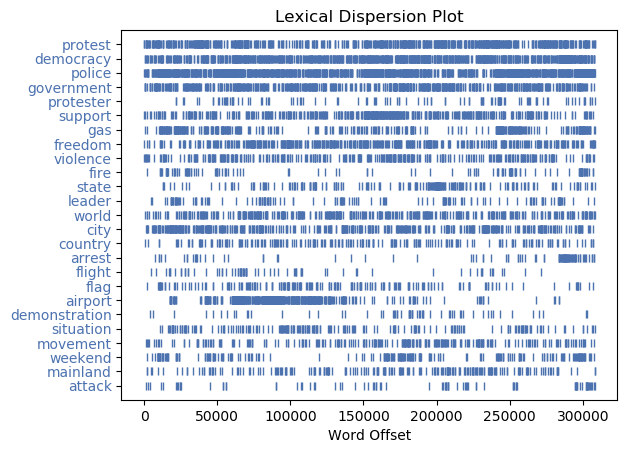

In [245]:
aText = nltk.Text(token)
sns.reset_orig() 
aText.dispersion_plot([ 'protest',
 'democracy',
 'police',
 'government',
 'protester',
 'support',
 'gas',
 'freedom',
 'violence',
 'fire',
 'state',
 'leader',
 'world',
 'city',
 'country',
 'arrest',
 'flight',
 'flag',
 'airport',
 'demonstration',
 'situation',
 'movement',
 'weekend',
 'mainland',
 'attack' ])
sns.set() 


## 6.2 Top Contributor Similarity Test¶

In [246]:
#creating a database with only top 15 contributors

In [247]:
aug_topdf = augdf

In [248]:
aug_topdf = aug_topdf.sort_values(by=['top_contributor'], ascending=False)
aug_topdf=aug_topdf.reset_index(drop=True)

In [249]:
aug_topdf[:3]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-08-19 15:42:03+00:00,HongKongFP,"[Recap] 'Tiananmen Square' crackdown in Hong Kong would harm trade deal, says US Pres. Trump #Ho...",31,45,2019-08-19,"[Recap, Tiananmen, Square, crackdown, in, Hong, Kong, would, harm, trade, deal, says, US, Pres, ...","[recap, tiananmen, square, crackdown, hong, kong, harm, trade, deal, says, pres, trump, hongkong...","[[Recap], [Tiananmen, Square, crackdown, in, Hong, Kong, would, harm, trade, deal, says, US, Pre...","[[recap], [tiananmen, square, crackdown, hong, kong, harm, trade, deal, say, pres], [trump, hong...",76.0,1,"[[(recap, NNP), (tiananmen, NNP), (square, NNP), (crackdown, NNP), (hong, NNP), (kong, NNP), (ha..."
1,2019-08-15 02:28:01+00:00,HongKongFP,Tear gas in Sham Shui Po for third time in 9 days as Hong Kong police clear roads during 'ghost ...,92,94,2019-08-15,"[Tear, gas, in, Sham, Shui, Po, for, third, time, in, 9, days, as, Hong, Kong, police, clear, ro...","[tear, gas, sham, shui, po, time, days, hong, kong, police, clear, roads, ghost, festival, demo,...","[[Tear, gas, in, Sham, Shui, Po, for, third, time, in, 9, days, as, Hong, Kong, police, clear, r...","[[tear, gas, sham, shui, po, time, day, hong, kong, police, clear, road, ghost, festival, demo, ...",186.0,1,"[[(tear, JJ), (gas, NN), (sham, NNP), (shui, NNP), (po, NNP), (time, NNP), (day, NNP), (hong, NN..."
2,2019-08-27 03:01:57+00:00,Reuters,"Hong Kong protests fuel buyer interest in luxury Australia, New Zealand homes https://reut.rs/2z...",19,36,2019-08-27,"[Hong, Kong, protests, fuel, buyer, interest, in, luxury, Australia, New, Zealand, homes, https:...","[hong, kong, protests, fuel, buyer, interest, luxury, australia, new, zealand, homes, https://re...","[[Hong, Kong, protests, fuel, buyer, interest, in, luxury, Australia, New, Zealand, homes, https...","[[hong, kong, protest, fuel, buyer, interest, luxury, australia, new, zealand, home, https://reu...",55.0,1,"[[(hong, NNP), (kong, NNP), (protest, NN), (fuel, NN), (buyer, NN), (interest, NN)], [(luxury, N..."


In [254]:
for i in range (len(aug_topdf)):
    if aug_topdf['top_contributor'][i] == 0:
        print (i)
        break 


In [255]:
aug_topdf = aug_topdf.drop(aug_topdf.index[854:])

In [256]:
aug_topdf[:3]

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-08-15 09:05:00+00:00,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...,213,142,2019-08-15,"[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sports...","[update, thousands, chinese, military, personnel, waving, red, flags, paraded, sports, stadium, ...","[[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sport...","[[update, thousand, chinese, military, personnel, wave, red, flag, parade, sport, stadium, shenz...",355.0,1,"[[(update, VB), (thousand, CD), (chinese, JJ), (military, JJ), (personnel, NNS), (wave, VBP), (r..."
1,2019-08-13 13:15:00+00:00,AFP,VIDEO: Hundreds of flights have been cancelled or suspended at Hong Kong's airport as pro-democr...,193,236,2019-08-13,"[VIDEO, Hundreds, of, flights, have, been, cancelled, or, suspended, at, Hong, Kong, 's, airport...","[video, hundreds, flights, cancelled, suspended, hong, kong, airport, pro, democracy, protesters...","[[VIDEO], [Hundreds, of, flights, have, been, cancelled, or, suspended, at, Hong, Kong, 's, airp...","[[video], [hundred, flight, cancel, suspend, hong, kong, airport, pro, democracy, protester, sta...",429.0,1,"[[(video, NNP), (hundred, CD), (flight, NN), (cancel, NN), (suspend, NN), (hong, NNP), (kong, NN..."
2,2019-08-20 04:18:00+00:00,AFP,Hong Kong protesters walk tightrope between peace and violence http://u.afp.com/JBXV,31,48,2019-08-20,"[Hong, Kong, protesters, walk, tightrope, between, peace, and, violence, http://u.afp.com/JBXV]","[hong, kong, protesters, walk, tightrope, peace, violence, http://u.afp.com/jbxv]","[[Hong, Kong, protesters, walk, tightrope, between, peace, and, violence, http://u.afp.com/JBXV]]","[[hong, kong, protester, walk, tightrope, peace, violence, http://u.afp.com/jbxv]]",79.0,1,"[[(hong, NNP), (kong, NNP), (protester, NNP), (walk, VBP), (tightrope, VB), (peace, NN), (violen..."


In [257]:
aug_topdf = aug_topdf.sort_values(by=['username'], ascending=True)
aug_topdf=aug_topdf.reset_index(drop=True)

In [258]:
aug_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-08-15 09:05:00+00:00,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...,213,142,2019-08-15,"[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sports...","[update, thousands, chinese, military, personnel, waving, red, flags, paraded, sports, stadium, ...","[[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sport...","[[update, thousand, chinese, military, personnel, wave, red, flag, parade, sport, stadium, shenz...",355.0,1,"[[(update, VB), (thousand, CD), (chinese, JJ), (military, JJ), (personnel, NNS), (wave, VBP), (r..."
1,2019-08-07 20:22:00+00:00,AFP,As Hong Kong buckles under increasingly violent clashes between protesters and police in a deepe...,20,34,2019-08-07,"[As, Hong, Kong, buckles, under, increasingly, violent, clashes, between, protesters, and, polic...","[hong, kong, buckles, increasingly, violent, clashes, protesters, police, deepening, political, ...","[[As, Hong, Kong, buckles, under, increasingly, violent, clashes, between, protesters, and, poli...","[[hong, kong, buckle, increasingly, violent, clash, protester, police, deepen, political, crisis...",54.0,1,"[[(hong, NNP), (kong, NNP), (buckle, NNP), (increasingly, RB), (violent, JJ), (clash, NN), (prot..."
2,2019-08-19 18:41:49+00:00,AFP,#BREAKING Twitter says China used service to sow Hong Kong discord,117,95,2019-08-19,"[BREAKING, Twitter, says, China, used, service, to, sow, Hong, Kong, discord]","[breaking, twitter, says, china, service, sow, hong, kong, discord]","[[], [BREAKING, Twitter, says, China, used, service, to, sow, Hong, Kong, discord]]","[[], [break, twitter, say, china, service, sow, hong, kong, discord]]",212.0,1,"[[( , _SP), (break, NN), (twitter, NN), (say, VBP), (china, NNP), (service, NNP), (sow, VBP), (h..."
3,2019-08-24 02:51:17+00:00,AFP,#BREAKING UK consulate staffer returns to Hong Kong after China detention: family,50,41,2019-08-24,"[BREAKING, UK, consulate, staffer, returns, to, Hong, Kong, after, China, detention, family]","[breaking, uk, consulate, staffer, returns, hong, kong, china, detention, family]","[[BREAKING, UK, consulate, staffer, returns, to, Hong, Kong, after, China, detention, family]]","[[break, uk, consulate, staffer, return, hong, kong, china, detention, family]]",91.0,1,"[[(break, VB), (uk, NNP), (consulate, NNP), (staffer, NNP), (return, NN), (hong, NNP), (kong, NN..."
4,2019-08-12 09:02:13+00:00,AFP,"VIDEO: Watch as thousands of protesters hold a sit-in protest at Hong Kong airport, one day afte...",212,209,2019-08-12,"[VIDEO, Watch, as, thousands, of, protesters, hold, a, sit, in, protest, at, Hong, Kong, airport...","[video, watch, thousands, protesters, hold, sit, protest, hong, kong, airport, day, police, fire...","[[VIDEO], [Watch, as, thousands, of, protesters, hold, a, sit, in, protest, at, Hong, Kong, airp...","[[video], [watch, thousand, protester, hold, sit, protest, hong, kong, airport, day, police, fir...",421.0,1,"[[(video, NN), (watch, VB)], [(thousand, CD), (protester, NN), (hold, NN), (sit, NN), (protest, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,2019-08-20 05:30:05+00:00,nytimes,"Watch: For more than 2 months, antigovernment protests have gripped Hong Kong, with anger rising...",66,125,2019-08-20,"[Watch, For, more, than, 2, months, antigovernment, protests, have, gripped, Hong, Kong, with, a...","[watch, months, antigovernment, protests, gripped, hong, kong, anger, rising, china, growing, in...","[[Watch, For, more, than, 2, months, antigovernment, protests, have, gripped, Hong, Kong, with, ...","[[watch, month, antigovernment, protest, grip, hong, kong, anger, rise, china, grow, influence],...",191.0,1,"[[(watch, VB), (month, NN), (antigovernment, NNP), (protest, NN), (grip, NNP)], [(ho

In [259]:
aug_topdf = aug_topdf.sort_values(by=['username'], ascending=True)
aug_topdf

,date,username,text,retweets,favorites,clean date,tokenized_words,normalized_words,tokenized_sents,normalized_sents,pop,top_contributor,POS_sents
0,2019-08-15 09:05:00+00:00,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...,213,142,2019-08-15,"[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sports...","[update, thousands, chinese, military, personnel, waving, red, flags, paraded, sports, stadium, ...","[[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sport...","[[update, thousand, chinese, military, personnel, wave, red, flag, parade, sport, stadium, shenz...",355.0,1,"[[(update, VB), (thousand, CD), (chinese, JJ), (military, JJ), (personnel, NNS), (wave, VBP), (r..."
31,2019-08-13 13:15:00+00:00,AFP,VIDEO: Hundreds of flights have been cancelled or suspended at Hong Kong's airport as pro-democr...,193,236,2019-08-13,"[VIDEO, Hundreds, of, flights, have, been, cancelled, or, suspended, at, Hong, Kong, 's, airport...","[video, hundreds, flights, cancelled, suspended, hong, kong, airport, pro, democracy, protesters...","[[VIDEO], [Hundreds, of, flights, have, been, cancelled, or, suspended, at, Hong, Kong, 's, airp...","[[video], [hundred, flight, cancel, suspend, hong, kong, airport, pro, democracy, protester, sta...",429.0,1,"[[(video, NNP), (hundred, CD), (flight, NN), (cancel, NN), (suspend, NN), (hong, NNP), (kong, NN..."
32,2019-08-20 04:18:00+00:00,AFP,Hong Kong protesters walk tightrope between peace and violence http://u.afp.com/JBXV,31,48,2019-08-20,"[Hong, Kong, protesters, walk, tightrope, between, peace, and, violence, http://u.afp.com/JBXV]","[hong, kong, protesters, walk, tightrope, peace, violence, http://u.afp.com/jbxv]","[[Hong, Kong, protesters, walk, tightrope, between, peace, and, violence, http://u.afp.com/JBXV]]","[[hong, kong, protester, walk, tightrope, peace, violence, http://u.afp.com/jbxv]]",79.0,1,"[[(hong, NNP), (kong, NNP), (protester, NNP), (walk, VBP), (tightrope, VB), (peace, NN), (violen..."
33,2019-08-24 08:43:08+00:00,AFP,#BREAKING Riot police baton-charge Hong Kong protesters,74,43,2019-08-24,"[BREAKING, Riot, police, baton, charge, Hong, Kong, protesters]","[breaking, riot, police, baton, charge, hong, kong, protesters]","[[BREAKING, Riot, police, baton, charge, Hong, Kong, protesters]]","[[break, riot, police, baton, charge, hong, kong, protester]]",117.0,1,"[[(break, VB), (riot, NN), (police, NNP), (baton, NNP), (charge, NNP), (hong, NNP), (kong, NNP),..."
34,2019-08-11 01:37:09+00:00,AFP,"Tensions in Hong Kong ripple across Australian universities, as supporters of the pro-democracy ...",56,63,2019-08-11,"[Tensions, in, Hong, Kong, ripple, across, Australian, universities, as, supporters, of, the, pr...","[tensions, hong, kong, ripple, australian, universities, supporters, pro, democracy, protests, t...","[[Tensions, in, Hong, Kong, ripple, across, Australian, universities, as, supporters, of, the, p...","[[tension, hong, kong, ripple, australian, university, supporter, pro, democracy, protest, targe...",119.0,1,"[[(tension, NN), (hong, NNP), (kong, NNP)], [(ripple, NNP), (australian, NNP), (university, NNP)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,2019-08-27 21:30:04+00:00,nytimes,"“Just last Friday, I went to do my nails with my close friend and then we had Japanese food. It ...",69,191,2019-08-27,"[Just, last, Friday, I, went, to, do, my, nails, with, my, close, friend, and, then, we, had, Ja...","[friday, went, nails, close, friend, japanese, food, sounds, funny, day, facing, tear, gas, risk...","[[Just, last, Friday, I, went, to, do, my, nails, with, my, close, friend], [and, then, we, had,...","[[friday, go, nail, close, friend], [japanese, food], [sound, funny, day, face, tear, gas, risk,...",260.0,1,"[[(friday, NNP), (go, VBP), (nail, NN), (close, JJ), (friend, NN), (japanese, JJ), (food, NN), (..."
822,2019-08-22 10:15:0

In [455]:
aug_username = aug_topdf['username'].tolist()

aug_countedWords = wordCounter(aug_username)
aug_countedWords

,word,count
0,afp,1
1,cnn,1
2,carlzha,1
3,chinadaily,1
4,hongkongfp,1
5,quicktake,1
6,reuters,1
7,scmpnews,1
8,time,1
9,wsj,1


In [262]:
aug_topdf = aug_topdf.drop(columns=['date','retweets','favorites','clean date','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])
aug_topdf

,username,text,tokenized_sents,normalized_sents
0,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...,"[[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sport...","[[update, thousand, chinese, military, personnel, wave, red, flag, parade, sport, stadium, shenz..."
31,AFP,VIDEO: Hundreds of flights have been cancelled or suspended at Hong Kong's airport as pro-democr...,"[[VIDEO], [Hundreds, of, flights, have, been, cancelled, or, suspended, at, Hong, Kong, 's, airp...","[[video], [hundred, flight, cancel, suspend, hong, kong, airport, pro, democracy, protester, sta..."
32,AFP,Hong Kong protesters walk tightrope between peace and violence http://u.afp.com/JBXV,"[[Hong, Kong, protesters, walk, tightrope, between, peace, and, violence, http://u.afp.com/JBXV]]","[[hong, kong, protester, walk, tightrope, peace, violence, http://u.afp.com/jbxv]]"
33,AFP,#BREAKING Riot police baton-charge Hong Kong protesters,"[[BREAKING, Riot, police, baton, charge, Hong, Kong, protesters]]","[[break, riot, police, baton, charge, hong, kong, protester]]"
34,AFP,"Tensions in Hong Kong ripple across Australian universities, as supporters of the pro-democracy ...","[[Tensions, in, Hong, Kong, ripple, across, Australian, universities, as, supporters, of, the, p...","[[tension, hong, kong, ripple, australian, university, supporter, pro, democracy, protest, targe..."
...,...,...,...,...
823,nytimes,"“Just last Friday, I went to do my nails with my close friend and then we had Japanese food. It ...","[[Just, last, Friday, I, went, to, do, my, nails, with, my, close, friend], [and, then, we, had,...","[[friday, go, nail, close, friend], [japanese, food], [sound, funny, day, face, tear, gas, risk,..."
822,nytimes,"Watch: The anti-government protests in Hong Kong have raged all summer, aided by the activism of...","[[Watch], [The, anti, government, protests, in, Hong, Kong, have, raged, all, summer, aided, by,...","[[watch], [anti, government, protest, hong, kong, rage, summer, aid, activism, city, student], [..."
852,nytimes,It's been over 80 days since the mass demonstrations in Hong Kong first started. That means the ...,"[[It, 's, been, over, 80, days, since, the, mass, demonstrations, in, Hong, Kong, first, started...","[[day, mass, demonstration, hong, kong, start], [mean, protest, last, long, umbrella, movement],..."
836,nytimes,"In his most extensive comments on the months of unrest in Hong Kong, President Trump said that C...","[[In, his, most, extensive, comments, on, the, months, of, unrest, in, Hong, Kong, President, Tr...","[[extensive, comment, month, unrest, hong, kong, president, trump, say, china, humanely, settle,..."


In [263]:
aug_topdf = aug_topdf.groupby(['username'], as_index = False).agg({'text': ''.join})


In [264]:
pandas.options.display.max_colwidth = 100
aug_topdf

,username,text
0,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...
1,CNN,"A Hong Kong citizen working for the British consulate, who has not been heard from for two weeks..."
2,CarlZha,"Now Hong Kong police is Beijing-backed forces, when will you call Hong Kong Protesters “moderate..."
3,ChinaDaily,"Saturday saw illegal protests scatter across Hong Kong, from the sit-in at the Hong Kong Interna..."
4,HongKongFP,Protesters call for pro-democracy 'human chain' across Hong Kong on 30th anniversary of the Balt...
5,QuickTake,Did protesters go too far at Hong Kong's airport? Here's what 24-year-old Saf says #HongKongPro...
6,Reuters,LIVE: Hong Kong police fire tear gas at protesters in Tai Wai Four Hong Kong stations close to h...
7,SCMPNews,"""We can be disappointed, but we cannot lose hope."" - Hong Kong's secondary school students are k..."
8,TIME,Hong Kong police confront protesters in ninth week of demonstrations with no end in sight http:/...
9,WSJ,Antigovernment protests in Hong Kong have prompted patriotic displays by Chinese in cities like ...


In [265]:
#tokenize and normalize

In [266]:
#tokenize words
aug_topdf['tokenized_words'] = aug_topdf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
aug_topdf['normalized_words'] = aug_topdf['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))


In [267]:
aug_topdf

,username,text,tokenized_words,normalized_words
0,AFP,#UPDATE Thousands of Chinese military personnel waving red flags paraded at a sports stadium in ...,"[UPDATE, Thousands, of, Chinese, military, personnel, waving, red, flags, paraded, at, a, sports...","[update, thousands, chinese, military, personnel, waving, red, flags, paraded, sports, stadium, ..."
1,CNN,"A Hong Kong citizen working for the British consulate, who has not been heard from for two weeks...","[A, Hong, Kong, citizen, working, for, the, British, consulate, who, has, not, been, heard, from...","[hong, kong, citizen, working, british, consulate, heard, weeks, detained, china, solicitation, ..."
2,CarlZha,"Now Hong Kong police is Beijing-backed forces, when will you call Hong Kong Protesters “moderate...","[Now, Hong, Kong, police, is, Beijing, backed, forces, when, will, you, call, Hong, Kong, Protes...","[hong, kong, police, beijing, backed, forces, hong, kong, protesters, moderate, rebels, hong, ko..."
3,ChinaDaily,"Saturday saw illegal protests scatter across Hong Kong, from the sit-in at the Hong Kong Interna...","[Saturday, saw, illegal, protests, scatter, across, Hong, Kong, from, the, sit, in, at, the, Hon...","[saturday, saw, illegal, protests, scatter, hong, kong, sit, hong, kong, international, airport,..."
4,HongKongFP,Protesters call for pro-democracy 'human chain' across Hong Kong on 30th anniversary of the Balt...,"[Protesters, call, for, pro, democracy, human, chain, across, Hong, Kong, on, 30th, anniversary,...","[protesters, pro, democracy, human, chain, hong, kong, 30th, anniversary, baltic, way, @krislc, ..."
5,QuickTake,Did protesters go too far at Hong Kong's airport? Here's what 24-year-old Saf says #HongKongPro...,"[Did, protesters, go, too, far, at, Hong, Kong, 's, airport, Here, 's, what, 24-year, old, Saf, ...","[protesters, far, hong, kong, airport, 24-year, old, saf, says, hongkongprotests, 香港機場, 香港this, ..."
6,Reuters,LIVE: Hong Kong police fire tear gas at protesters in Tai Wai Four Hong Kong stations close to h...,"[LIVE, Hong, Kong, police, fire, tear, gas, at, protesters, in, Tai, Wai, Four, Hong, Kong, stat...","[live, hong, kong, police, fire, tear, gas, protesters, tai, wai, hong, kong, stations, close, h..."
7,SCMPNews,"""We can be disappointed, but we cannot lose hope."" - Hong Kong's secondary school students are k...","[We, can, be, disappointed, but, we, can, not, lose, hope, Hong, Kong, 's, secondary, school, st...","[disappointed, lose, hope, hong, kong, secondary, school, students, keeping, faith, protesting, ..."
8,TIME,Hong Kong police confront protesters in ninth week of demonstrations with no end in sight http:/...,"[Hong, Kong, police, confront, protesters, in, ninth, week, of, demonstrations, with, no, end, i...","[hong, kong, police, confront, protesters, ninth, week, demonstrations, end, sight, http://mag.t..."
9,WSJ,Antigovernment protests in Hong Kong have prompted patriotic displays by Chinese in cities like ...,"[Antigovernment, protests, in, Hong, Kong, have, prompted, patriotic, displays, by, Chinese, in,...","[antigovernment, protests, hong, kong, prompted, patriotic, displays, chinese, cities, like, new..."


In [398]:
keywords = [(( 'protest',
 'democracy',
 'police',
 'government',
 'protester',
 'support',
 'gas',
 'freedom',
 'violence',
 'fire',
 'state',
 'leader',
 'world',
 'city',
 'country',
 'arrest',
 'flight',
 'flag',
 'airport',
 'demonstration',
 'situation',
 'movement',
 'weekend',
 'mainland',
 'attack' ) )]

taggedDocs = []
for index, row in aug_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['username'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
aug_topdf['TaggedAbstracts'] = taggedDocs

In [399]:
topD2V = gensim.models.doc2vec.Doc2Vec(aug_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [400]:
topD2V.docvecs[5]


array([-1.04124105e+00,  7.38638520e-01, -4.61886317e-01,  3.01578462e-01,
       -2.72424012e-01,  1.68988422e-01,  2.14660048e-01,  8.34475458e-02,
        3.10607821e-01, -1.98191866e-01, -1.12746336e-01,  5.63636757e-02,
        6.47451997e-01, -3.66634250e-01,  1.46452561e-01,  6.78394362e-02,
       -1.14455652e+00,  6.35671616e-01, -9.33515549e-01,  3.08195353e-01,
       -1.76265168e+00, -4.73190278e-01, -9.62137103e-01, -6.13731449e-04,
       -3.44617546e-01,  1.25687376e-01,  4.72507328e-01, -2.98662990e-01,
       -1.50452638e+00, -1.32368684e-01, -3.59535575e-01,  4.87948805e-01,
        4.70757484e-01,  1.14204943e-01,  9.01153445e-01,  4.41861272e-01,
       -2.02823311e-01, -6.25542641e-01, -6.22174442e-01, -7.75743484e-01,
        3.87396455e-01, -1.48764588e-02,  6.27978325e-01, -6.47711813e-01,
       -7.60146022e-01, -2.82750756e-01, -8.85283828e-01,  4.87889647e-01,
       -5.66098699e-03, -3.30321565e-02,  1.38712004e-01, -7.48004854e-01,
       -2.85065651e-01,  

In [401]:
targetDocs = aug_topdf['username']

heatmapMatrixD = []



for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

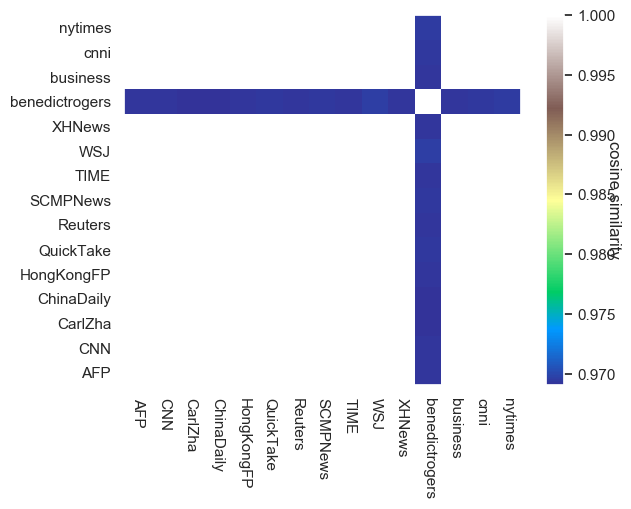

In [402]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [433]:
aug_topdf['text'][5]

' Did protesters go too far at Hong Kong\'s airport? Here\'s what 24-year-old Saf says #HongKongProtests #香港機場 #香港This is how micro-apartments are maximizing space in Hong Kong "We\'ve always wanted a platform for all the citizens who may not go out on the streets without approval." Organizers explain why they\'ve gathered in Hong Kong\'s Victoria Park after police rejected a separate planned demonstration #HongKongProtests #香港"The ultimate victim of these tactics will be the police force\'s already crumbling public image." Protesters say that the police\'s attempts at spreading fear and suppressing the freedom of press will backfire on the Hong Kong government #香港 #反送中 #HongKongProtestsJUST IN: Twitter says a "significant state-backed information operation" tried to sow "political discord" in Hong Kong WATCH: Black-clad #antiELAB protesters stream out of the Hong Kong airport #HongKongProtests #香港 Why are you carrying the American flag? Here\'s what this Hong Kong protester says #Hong

## 6.3 Semantic Influence Networks based on noun-verb pairs

In [404]:
aug_topdf['tokenized_sents'] = aug_topdf['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
aug_topdf['normalized_sents'] = aug_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])


In [405]:
import networkx as nx

In [406]:
g = posCooccurrence(aug_topdf['normalized_sents'].sum(), 'NN', 'VB')

In [407]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [408]:
len(g.nodes)

1109

In [409]:
len(g.edges)

2033

In [410]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [411]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(aug_topdf['text'])


In [412]:
tweetVects_incidence.shape


(15, 2793)

In [413]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [414]:

print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 2808
Number of edges: 5859
Average degree:   4.1731


In [415]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 15
Number of edges: 105
Average degree:  14.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


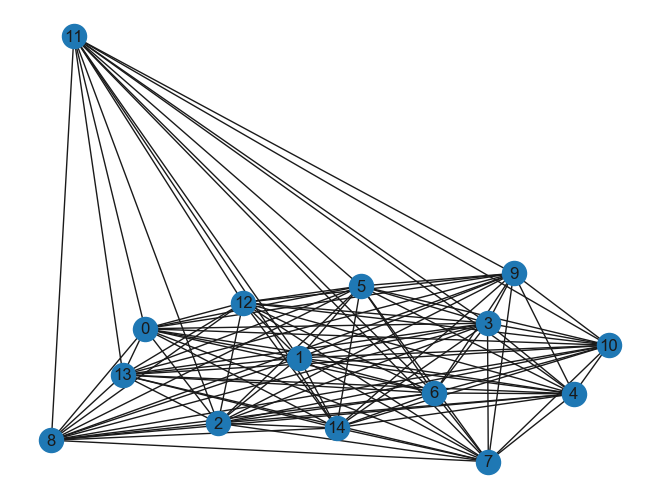

In [416]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [454]:
aug_topdf['text'][3]


'Saturday saw illegal protests scatter across Hong Kong, from the sit-in at the Hong Kong International Airport to waves of demonstrations in several locations in New Territories and Kowloon, disrupting traffic and daily life. #HongKong #Opinion For all the well-worded narratives, the demonstrators are trying to hold Hong Kong\'s prosperity and the well-being of its residents to political ransom. #HongKongA new round of protests erupted across Hong Kong. Police have made multiple arrests amid escalating violence. Is this the Hong Kong you wanted? Stop the violence, for a better #HongKong. #香港“I’m so heartbroken!” Hong Kong citizens denounce violence by radical protestors. The Hong Kong and Macao Affairs Office of the State Council on Monday strongly condemned radicals who threw petrol bombs at police officers on Sunday night. #HongKongTaxi drivers in Hong Kong are feeling the pinch of the protracted protests that often end up in road blockades and violence. They staged a peaceful parad